In [1]:
# import sys
import numpy as np
import pathlib
import sys

import petsc4py
petsc4py.init(sys.argv)
import dolfin as dl
import hippylib as hl

dl.parameters["form_compiler"]["optimize"]     = True
dl.parameters["form_compiler"]["cpp_optimize"] = True
dl.parameters["form_compiler"]["representation"] = "uflacs"
dl.parameters["form_compiler"]["cpp_optimize_flags"] = "-O3 -ffast-math -march=native"

# for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=4, rc={"lines.linewidth": 4})
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.unicode_minus'] = False

mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}", r"\usepackage{amssymb}"]

# Quasistatic problem

In [11]:
# import
from PDE_model_help import GenericReprBase, FwdModelSource, FwdBoundary
from PDE_model_help import Misfit, FullTracer
from PDE_model_help import plot_prior, run_and_compare_approximations
from PDE_model import PDEModel

STATE = 0
PARAMETER = 1

In [3]:
# run_dir = 'test/'
# theta0 = [0.25]
# use_approx = True
# which_est = 0
# noise_variance = np.power(0.01, 2)

# num_samples = 5000
# pcn_s = 0.2
# p_mode = np.array([0.5, 10.])
# p_sigma = np.array([0.4, 0.4])

# out_path = run_dir

# mcmc_path = run_dir # results in chain_<id> folder

In [4]:
run_dir = 'run_1/'
theta0 = [0.25]
use_approx = True
which_est = 0
noise_variance = np.power(0.01, 2)

num_samples = 5000
pcn_s = 0.2
p_mode = np.array([0.5, 10.])
p_sigma = np.array([0.4, 0.4])

out_path = run_dir

mcmc_path = run_dir # results in chain_<id> folder

In [5]:
# run_dir = 'run_2/'
# theta0 = [0.25]
# use_approx = False
# which_est = 0
# noise_variance = np.power(0.01, 2)

# num_samples = 5000
# pcn_s = 0.2
# p_mode = np.array([0.5, 10.])
# p_sigma = np.array([0.4, 0.4])

# out_path = run_dir

# mcmc_path = run_dir # results in chain_<id> folder

In [6]:
# run_dir = 'run_3/'
# theta0 = [0.25]
# use_approx = True
# which_est = 1
# noise_variance = np.power(0.01, 2)

# num_samples = 5000
# pcn_s = 0.2
# p_mode = np.array([0.5, 10.])
# p_sigma = np.array([0.4, 0.4])

# out_path = run_dir

# mcmc_path = run_dir # results in chain_<id> folder

In [7]:
# run_dir = 'run_4/'
# theta0 = [0.25]
# use_approx = True
# which_est = 0
# noise_variance = np.power(0.001, 2)

# num_samples = 5000
# pcn_s = 0.2
# p_mode = np.array([0.5, 10.])
# p_sigma = np.array([0.4, 0.4])

# out_path = run_dir

# mcmc_path = run_dir # results in chain_<id> folder

# Create prior

In [12]:
# mcmc chains
chain_ids = [i+1 for i in range(4)]
mcmc_paths_chain = [mcmc_path + 'chain_%d/' % (i) for i in chain_ids]
mcmc_plot_path = mcmc_path
out_path_chain = out_path + 'plot/'
mcmc_paths_chain

['run_1/chain_1/', 'run_1/chain_2/', 'run_1/chain_3/', 'run_1/chain_4/']

/home/prashant/Dropbox/Work/Simulations/python_works/GoalOrientedModelCalibration/Quasistatic_Problem/PDE_model_help.py:240: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(samples[:, idx], hist=False, norm_hist = True, ax=axs[row, col])
/home/prashant/Dropbox/Work/Simulations/python_works/GoalOrientedModelCalibration/Quasistatic_Problem/PDE_model_help.py:263: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to upd

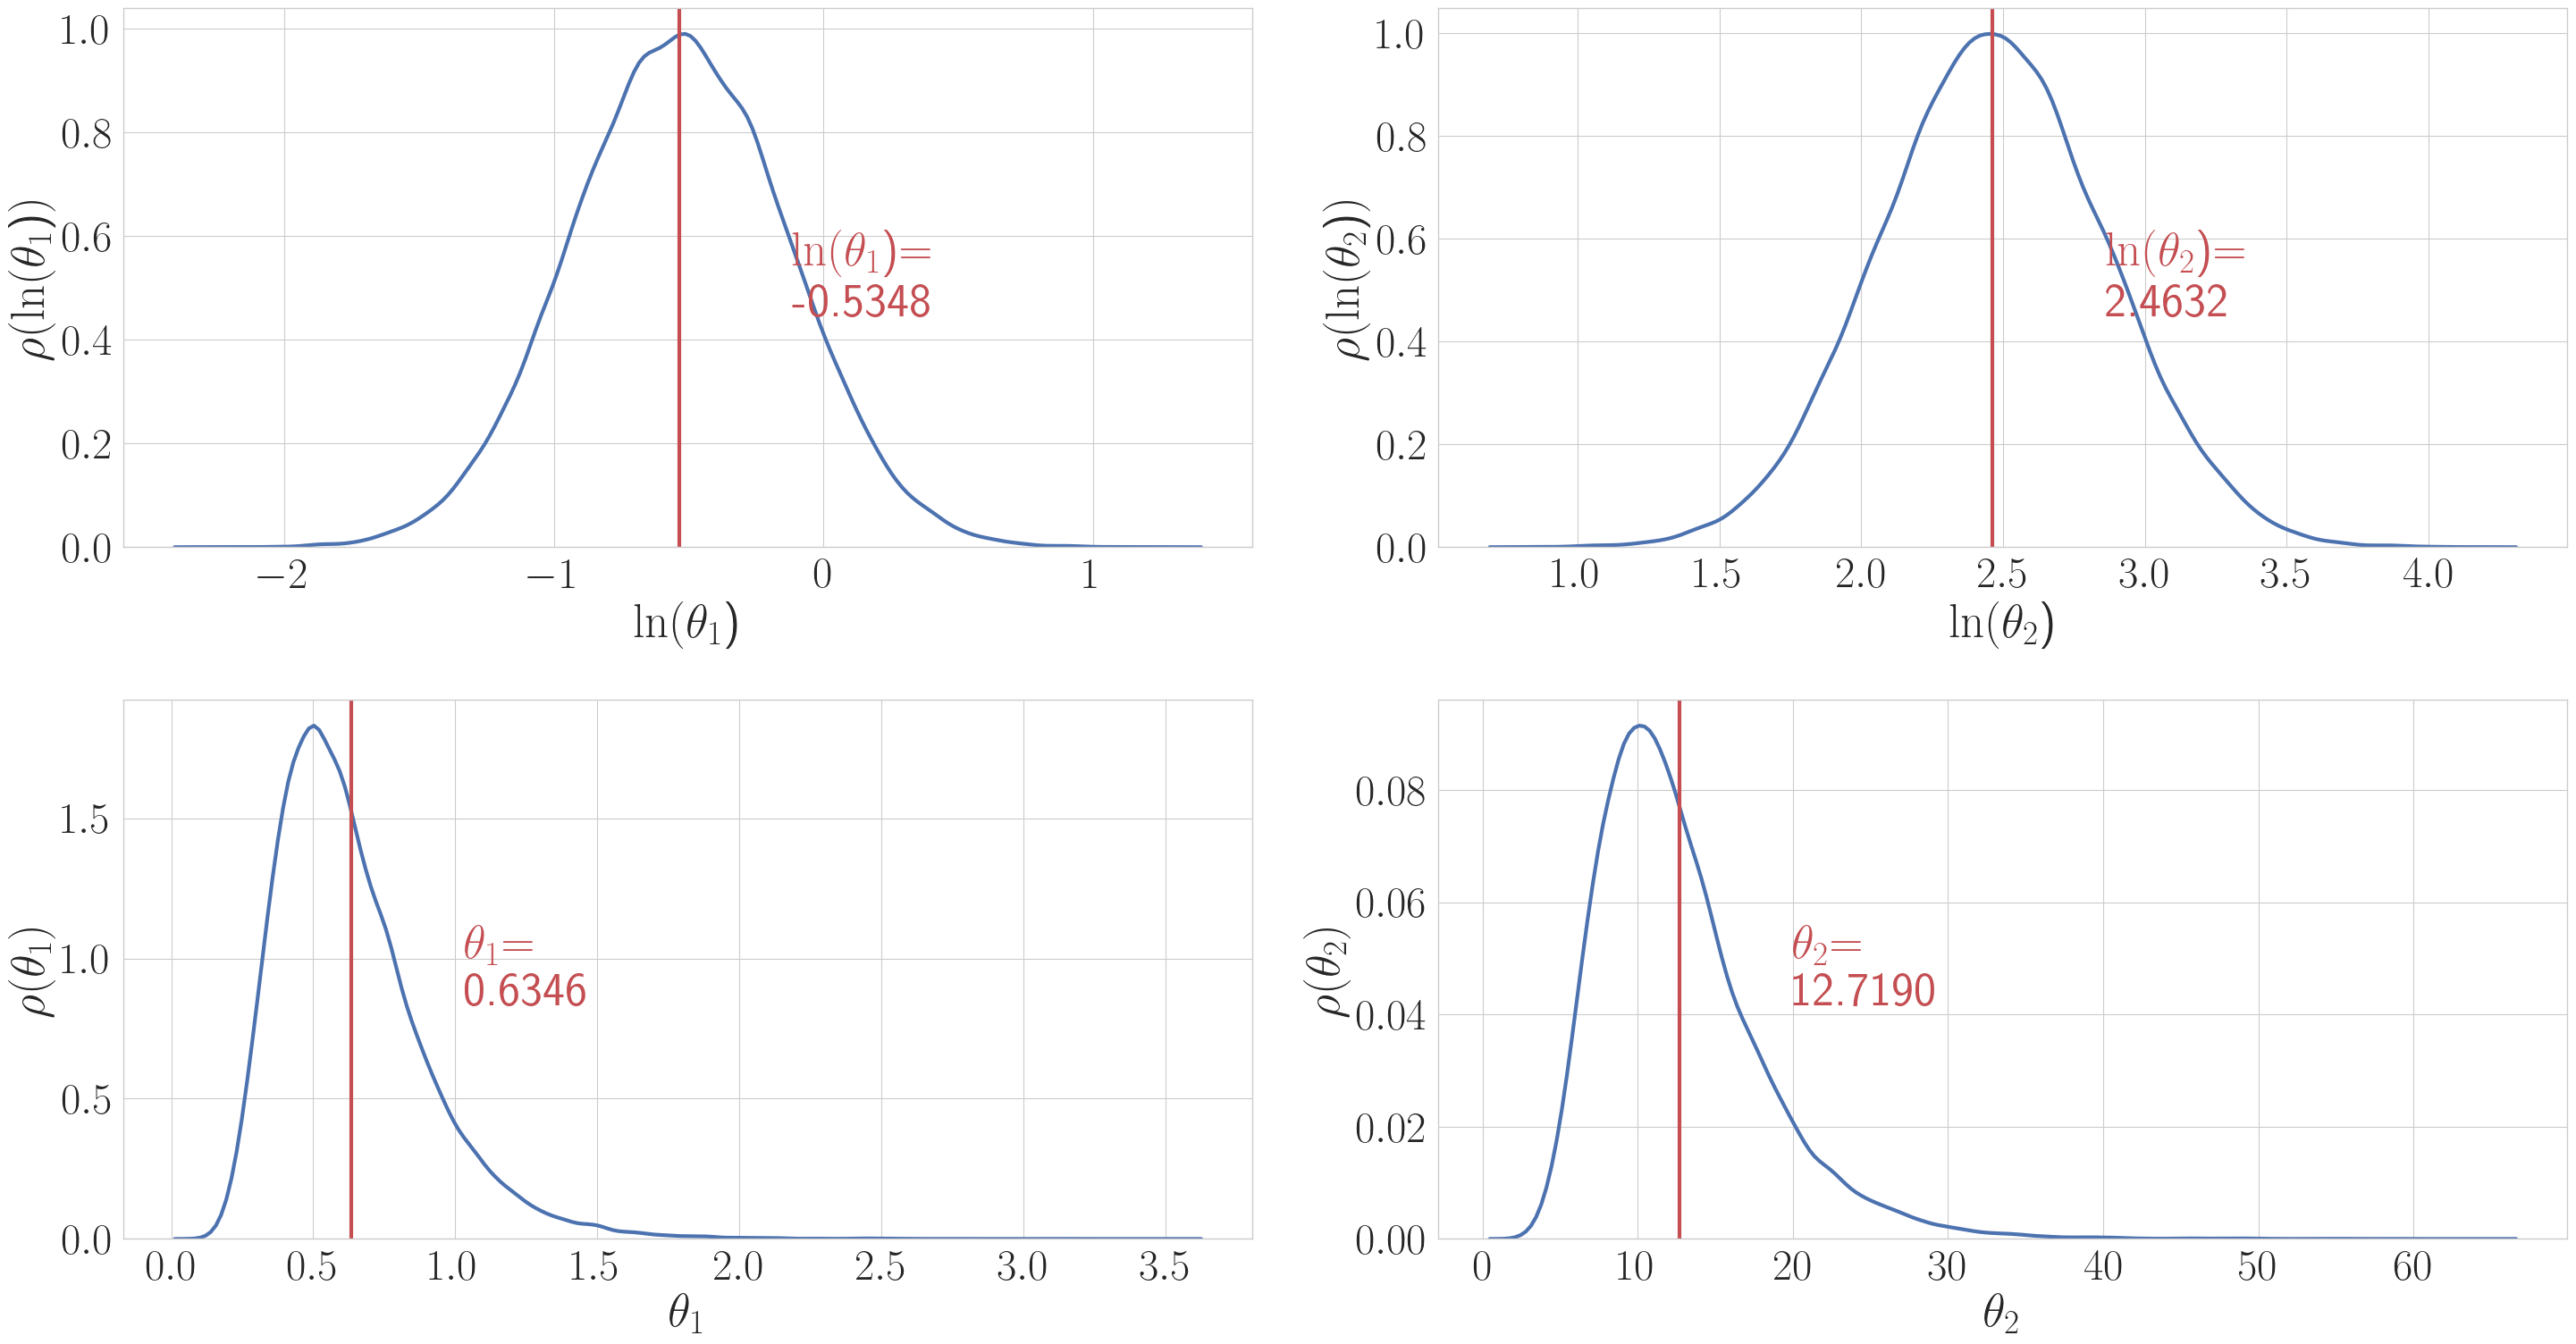

In [13]:
# load mesh
mesh = dl.RectangleMesh(dl.Point(0, 0), dl.Point(1,1), 50, 50)

# FE space
FE_polynomial = 1
Vu = dl.FunctionSpace(mesh, "Lagrange", FE_polynomial)

# Define elements: P1 and real number
P1  = dl.FiniteElement("Lagrange", mesh.ufl_cell(), 2)
R   = dl.FiniteElement("R", mesh.ufl_cell(), 0)

# parameter space
# k, alpha
param_dim = 2
Vh_PARAMETER = dl.VectorFunctionSpace(mesh, "R", degree=0, dim=param_dim)

# Define the state space (solution space) together with parameter space
Vh = [Vu, Vh_PARAMETER, None]

print_freq = 10

# create pde problem
pde = PDEModel(Vh, save = False, out_path = out_path_chain)
pde.print_freq = print_freq

pde.use_approx = use_approx
pde.which_est = which_est

# create misfit function
total_u = np.zeros((1,1))
misfit = Misfit(total_u)
misfit.set_noise_variance([noise_variance], no_scale = True)

# set prior distribution (mode from the validation data in the paper)
p_mean = np.log(p_mode) + p_sigma**2
mean = pde.generate_parameter()
mean.set_local(p_mean)

# prior distribution (lognormal)
prior = hl.GaussianRealPrior(Vh[PARAMETER], np.diag(p_sigma**2), mean=mean)

# plot prior
plot_prior(prior)


# generate prior samples
noise = dl.Vector()
prior.init_vector(noise,"noise")
hl.parRandom.normal(1., noise)
m = dl.Vector()
prior.init_vector(m, 0)
n_samples = 50000
prior_samples = np.empty((n_samples, param_dim))
for i in range(n_samples):
    hl.parRandom.normal(1., noise)
    prior.sample(noise,m)
    prior_samples[i,:] = m.get_local()

# Process results

In [14]:
titles_real = [r'$\kappa$', r'$\alpha$']
titles = [r'$\ln(\kappa)$', r'$\ln(\alpha)$']

In [15]:
qoi_chains = {}
cost_chains = {}
acc_chains = {}
data_chains = {}
samples_chains = {}

qoi_status = [True for i in range(4)]

qoi, cost, acc, samples = None, None, None, None

total_samples = 0
for i in range(4):
    I = chain_ids[i]
    s = 'chain_%d' % (I)
    
    f = mcmc_paths_chain[i]
    
    # check if file exist
    qoi_exist = False
    f_check = pathlib.Path(f + 'qoi.npy')
    if f_check.is_file():
        qoi_exist = True
    
    if qoi_exist:
        qoi_I = np.load(f + 'qoi.npy')
        cost_I = np.load(f + 'cost.npy')
        acc_I = np.load(f + 'acceptance_rate.npy')
        data_I = np.load(f + 'data.npy')
        samples_I = np.load(f + 'param_samples.npy')

        print('chain = {}, num samples = {}'.format(I, len(qoi_I)))
        total_samples = total_samples + len(qoi_I)

        qoi_chains.update({s: qoi_I})
        cost_chains.update({s: cost_I})
        acc_chains.update({s: acc_I})
        data_chains.update({s: data_I})
        samples_chains.update({s: samples_I})

        if qoi is None:
            qoi = qoi_chains[s]
            cost = cost_chains[s]
            acc = acc_chains[s]
            samples = samples_chains[s]
        else:
            qoi = np.append(qoi, qoi_chains[s], axis = 0)
            cost = np.append(cost, cost_chains[s], axis = 0)
            acc = np.append(acc, acc_chains[s], axis = 0)
            samples = np.append(samples, samples_chains[s], axis = 0)
    else:
        print('chain = {}, num samples = {}'.format(I, 0))
        qoi_status[i] = False
        
        qoi_chains.update({s: None})
        cost_chains.update({s: None})
        acc_chains.update({s: None})
        data_chains.update({s: None})
        samples_chains.update({s: None})

print('total samples = {}'.format(total_samples))

chain = 1, num samples = 1350
chain = 2, num samples = 1359
chain = 3, num samples = 1390
chain = 4, num samples = 1432
total samples = 5531


In [16]:
# burn initial samples
burn_in = 0.5 

qoi_chains_burn = {}
cost_chains_burn = {}
acc_chains_burn = {}
data_chains_burn = {}
samples_chains_burn = {}

qoi_burn, cost_burn, acc_burn, samples_burn = None, None, None, None

total_samples = 0
for i in range(4):
    I = chain_ids[i]
    s = 'chain_%d' % (I)
    
    qoi_I = qoi_chains[s]
    if qoi_I is not None:
        Nstart = int(burn_in * len(qoi_chains[s]))
        qoi_chains_burn.update({s: qoi_chains[s][Nstart:]})
        cost_chains_burn.update({s: cost_chains[s][Nstart:]})
        acc_chains_burn.update({s: acc_chains[s][Nstart:]})
        samples_chains_burn.update({s: samples_chains[s][Nstart:]})

        print('chain = {}, num samples = {}'.format(I, len(qoi_chains_burn[s])))
        total_samples = total_samples + len(qoi_chains_burn[s])

        if qoi_burn is None:
            qoi_burn = qoi_chains_burn[s]
            cost_burn = cost_chains_burn[s]
            acc_burn = acc_chains_burn[s]
            samples_burn = samples_chains_burn[s]
        else:
            qoi_burn = np.append(qoi_burn, qoi_chains_burn[s], axis = 0)
            cost_burn = np.append(cost_burn, cost_chains_burn[s], axis = 0)
            acc_burn = np.append(acc_burn, acc_chains_burn[s], axis = 0)
            samples_burn = np.append(samples_burn, samples_chains_burn[s], axis = 0)
    else:
        print('chain = {}, num samples = {}'.format(I, 0))
        
        qoi_chains_burn.update({s: None})
        cost_chains_burn.update({s: None})
        acc_chains_burn.update({s: None})
        data_chains_burn.update({s: None})
        samples_chains_burn.update({s: None})

print('total samples after burn in = {}'.format(total_samples))

chain = 1, num samples = 675
chain = 2, num samples = 680
chain = 3, num samples = 695
chain = 4, num samples = 716
total samples after burn in = 2766


In [17]:
savefig = False
sfpath = mcmc_plot_path

In [18]:
prior_real_mean = [np.mean(np.exp(prior_samples[:, i])) for i in range(param_dim)]
prior_real_std = [np.std(np.exp(prior_samples[:, i])) for i in range(param_dim)]

posterior_real_mean = [np.mean(np.exp(samples_burn[:, i])) for i in range(param_dim)]
posterior_real_std = [np.std(np.exp(samples_burn[:, i])) for i in range(param_dim)]

print('prior mean and std (real)')
print(prior_real_mean)
print(prior_real_std)

print('posterior mean and std (real)')
print(posterior_real_mean)
print(posterior_real_std)

prior mean and std (real)
[0.6358711791488563, 12.754036345479099]
[0.26630195288402536, 5.314855143938664]
posterior mean and std (real)
[0.11839600326539802, 2.62795995443591]
[0.018226433661175087, 0.43294309787404955]


In [19]:
prior_ln_mean = [np.mean(prior_samples[:, i]) for i in range(param_dim)]
prior_ln_std = [np.std(prior_samples[:, i]) for i in range(param_dim)]

posterior_ln_mean = [np.mean(samples_burn[:, i]) for i in range(param_dim)]
posterior_ln_std = [np.std(samples_burn[:, i]) for i in range(param_dim)]

print('prior mean and std (ln)')
print(prior_ln_mean)
print(prior_ln_std)

print('posterior mean and std (ln)')
print(posterior_ln_mean)
print(posterior_ln_std)

prior mean and std (ln)
[-0.5331912691942302, 2.466337783716373]
[0.4007206904453346, 0.3982083787561017]
posterior mean and std (ln)
[-2.1461579130580013, 0.9525146718407502]
[0.16001265277477222, 0.16629493970801557]


# Plotting

In [20]:
def plot(data, x = None, xl = None, yl = None, \
         savefig = False, savefile = '', figsize = [10,10]):
    
    plt.figure(figsize = figsize)
    if x is not None:
        plt.plot(x, data)
    else:
        plt.plot(data)
    if xl is not None:
        plt.xlabel(xl)
    if yl is not None:
        plt.ylabel(yl)
    plt.tight_layout()
    if savefig:
        plt.savefig(savefile)
    plt.show()

# Plot one chain

In [21]:
for i in range(4):
    plot_chain_id = i
    if qoi_status[plot_chain_id]:
        break
plot_chain = 'chain_%d' % (plot_chain_id + 1)
sfpath_chain = mcmc_paths_chain[plot_chain_id]
sfpath_chain

'run_1/chain_1/'

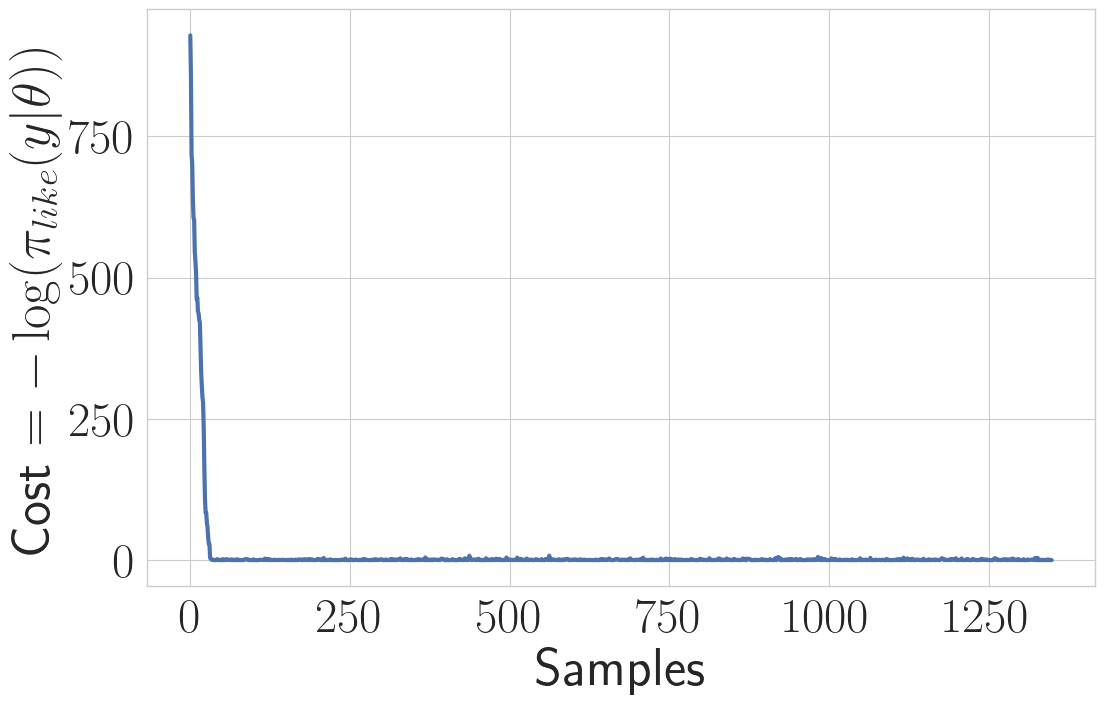

In [22]:
plot(cost_chains[plot_chain], xl=r'Samples', yl= r'Cost = $-\log(\pi_{like}(y | {\theta}))$', \
     savefig = savefig, savefile = sfpath_chain + 'cost_' + plot_chain + '.pdf', figsize=[12,8])

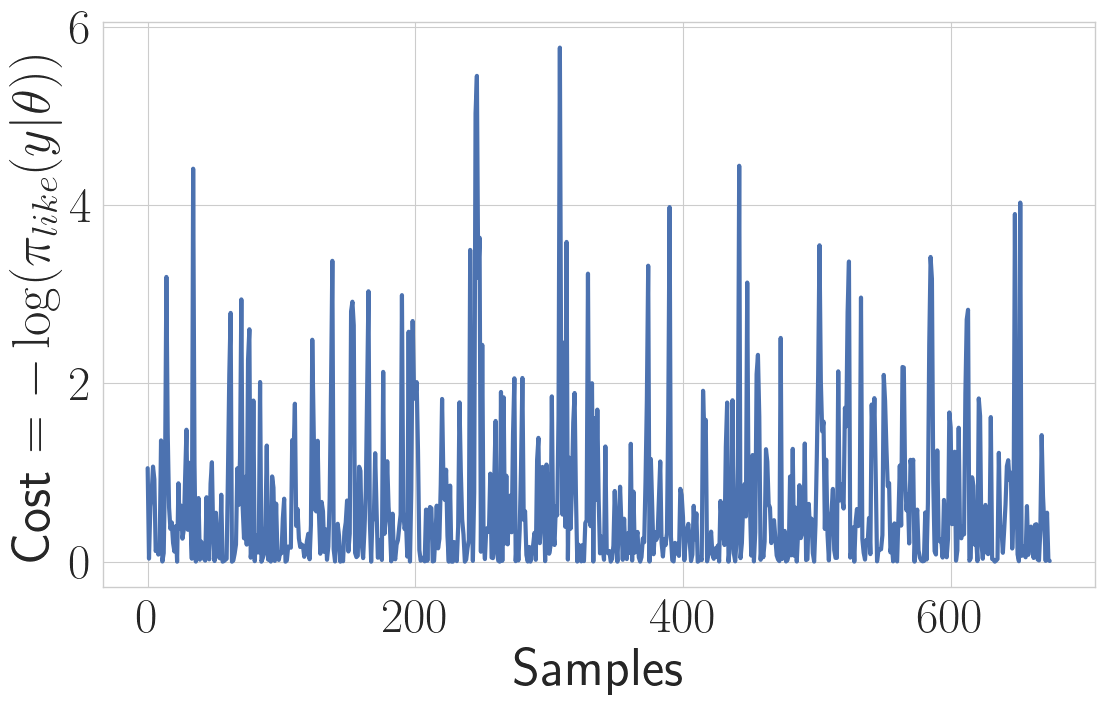

In [23]:
plot(cost_chains_burn[plot_chain], xl=r'Samples', yl= r'Cost = $-\log(\pi_{like}(y | \theta))$', \
     savefig = savefig, savefile = sfpath_chain + 'cost_burn_' + plot_chain + '.pdf', figsize=[12,8])

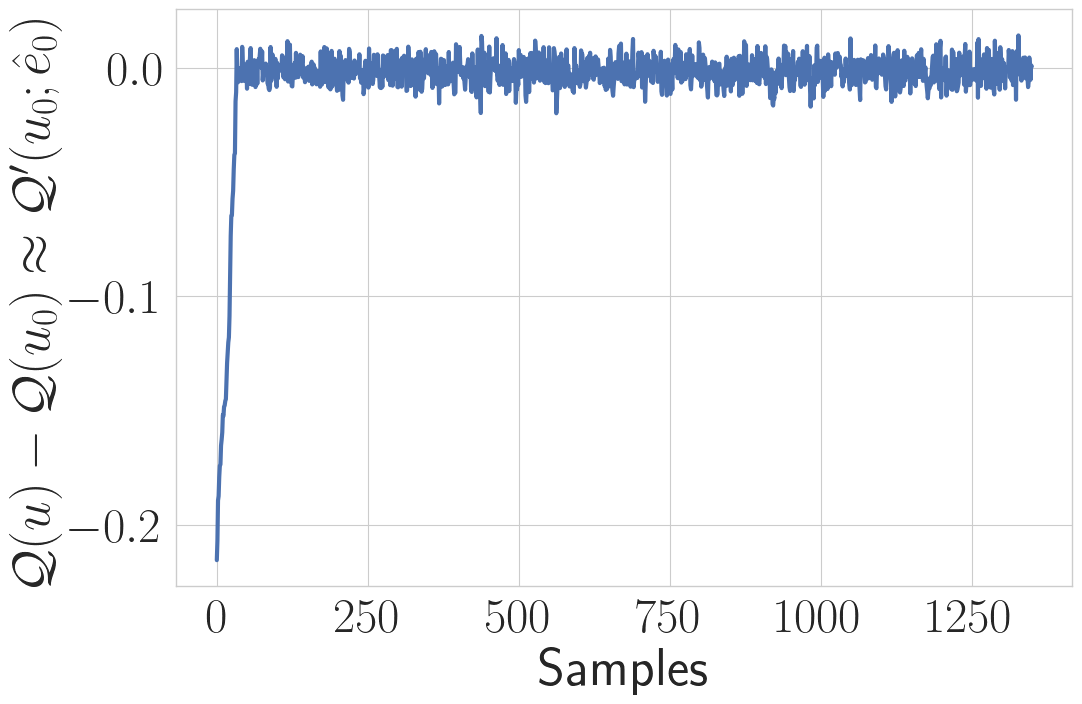

In [24]:
plot(qoi_chains[plot_chain], xl=r'Samples', \
     yl=r"$\mathcal{Q}(u) - \mathcal{Q}(u_0) \approx \mathcal{Q}'(u_0; \hat{e}_0)$", \
     savefig = savefig, savefile = sfpath_chain + 'qoi_{}.pdf'.format(plot_chain), figsize=[12,8])

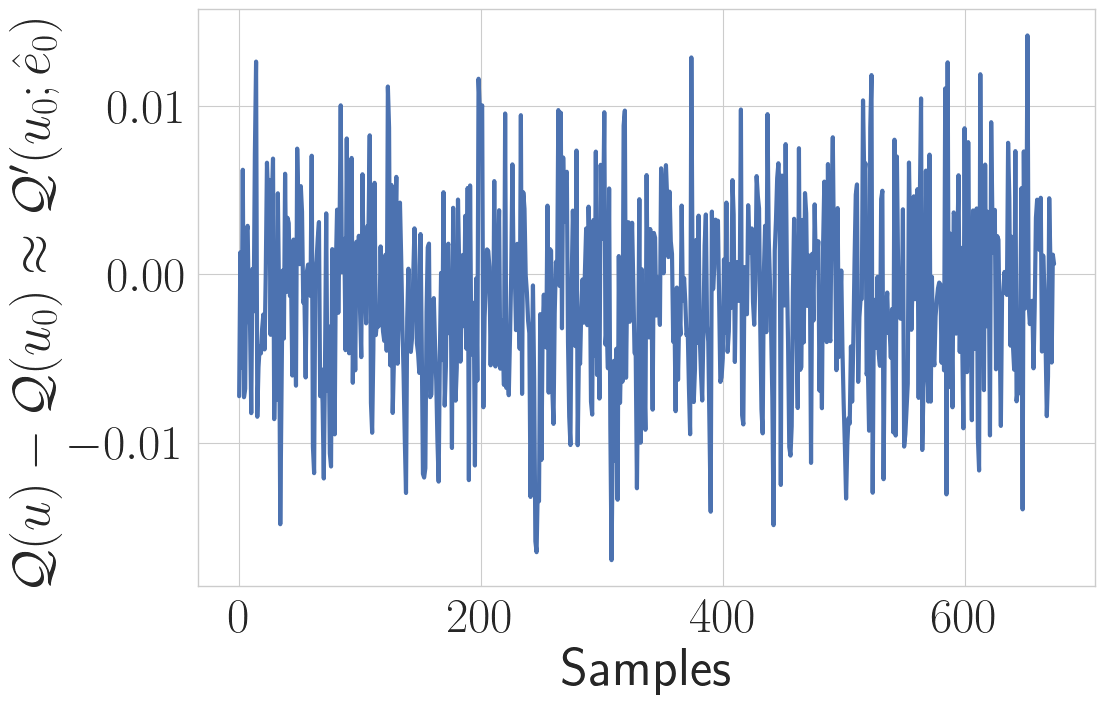

In [25]:
plot(qoi_chains_burn[plot_chain], xl=r'Samples', \
     yl=r"$\mathcal{Q}(u) - \mathcal{Q}(u_0) \approx \mathcal{Q}'(u_0; \hat{e}_0)$", \
     savefig = savefig, savefile = sfpath_chain + 'qoi_burn_{}.pdf'.format(plot_chain), figsize=[12,8])

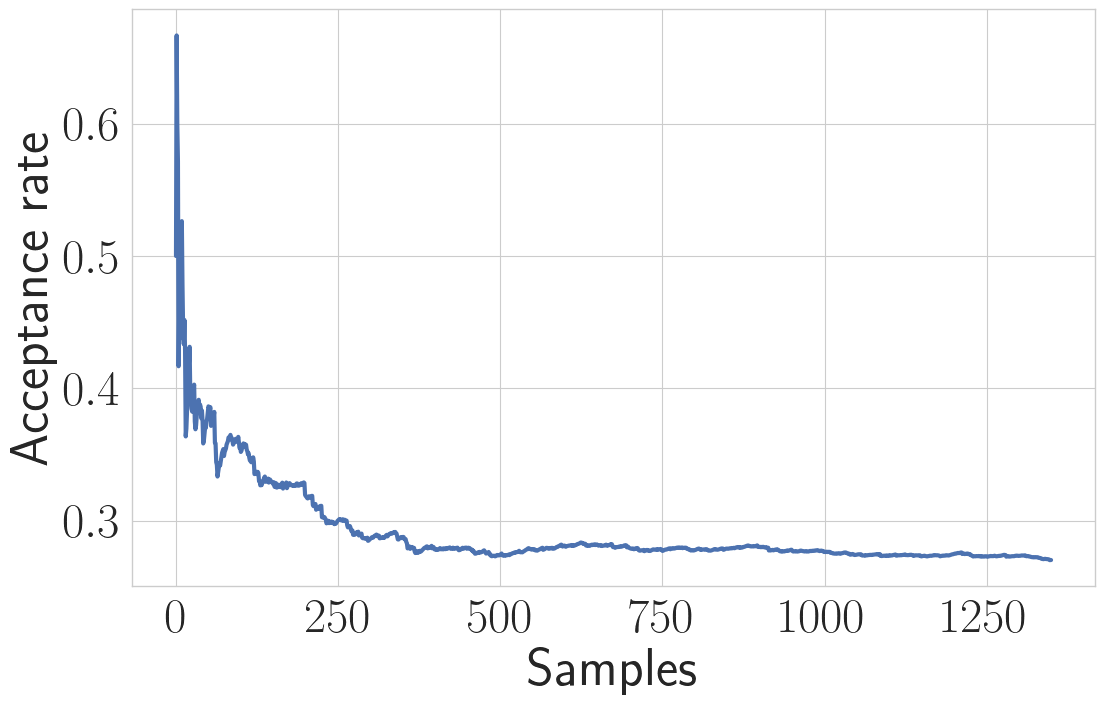

In [26]:
plot(acc_chains[plot_chain], xl = r'Samples', yl= r'Acceptance rate', \
     savefig = savefig, savefile = sfpath_chain + 'acc_{}.pdf'.format(plot_chain), figsize=[12,8])

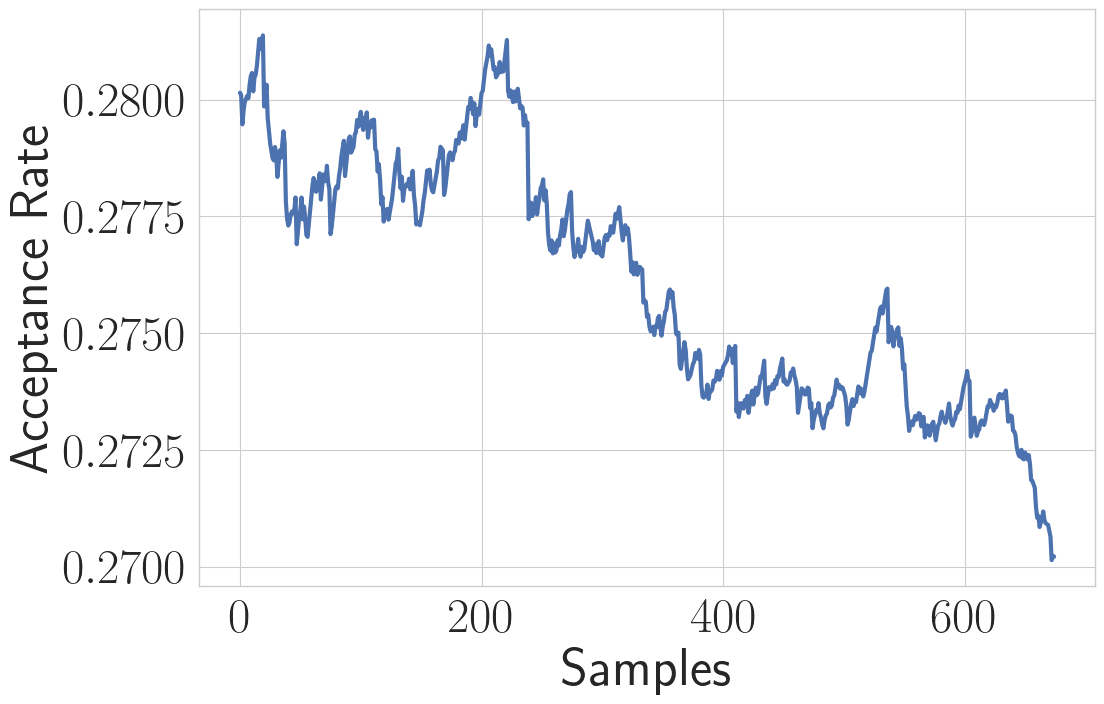

In [27]:
plot(acc_chains_burn[plot_chain], xl = r'Samples', yl= r'Acceptance Rate', \
     savefig = savefig, savefile = sfpath_chain + 'acc_burn_{}.pdf'.format(plot_chain), figsize=[12,8])

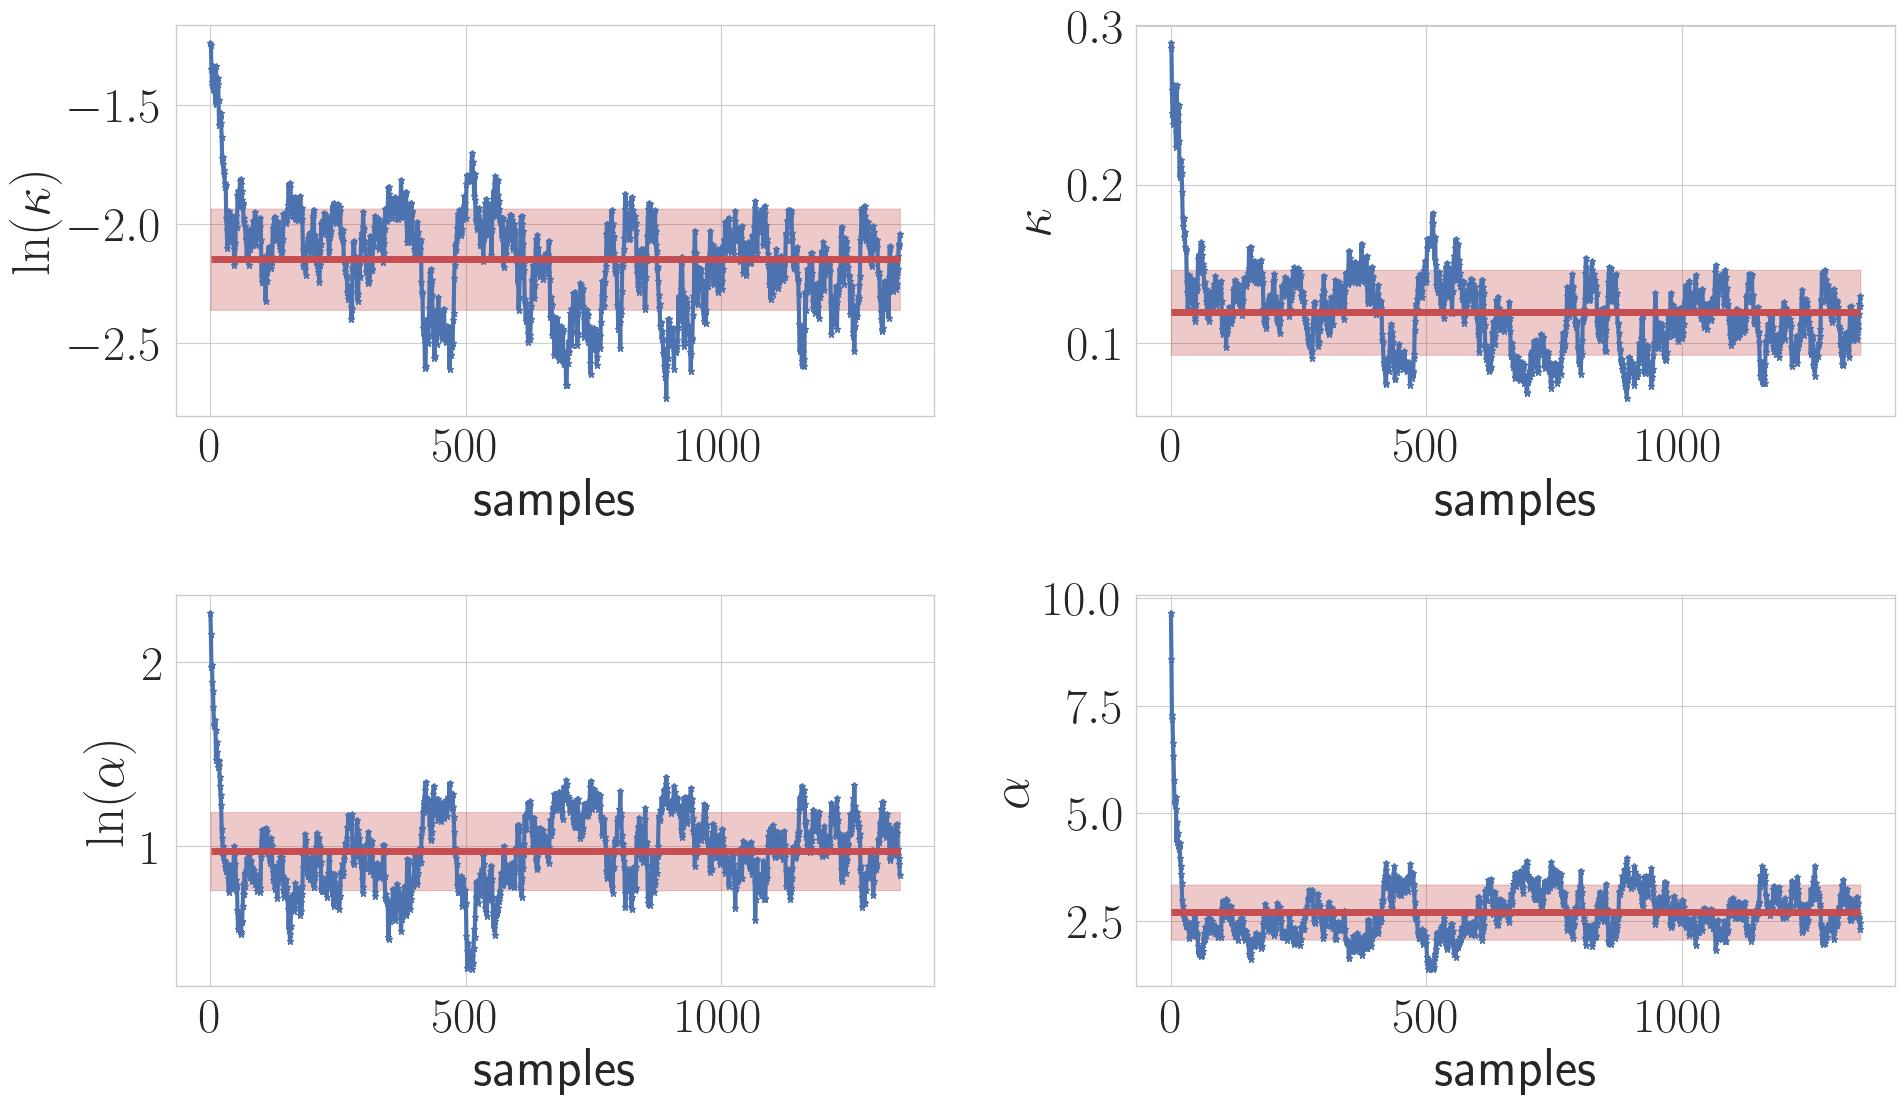

In [28]:
plot_samples = samples_chains[plot_chain]

fig, axs = plt.subplots(nrows=param_dim, ncols=2, figsize=(20, 12))

# get real samples
plot_samples_real = np.exp(plot_samples)

# get mean in ln and real spaces
plot_samples_mean = [np.mean(plot_samples[:, i]) for i in range(param_dim)]
plot_samples_std = [np.std(plot_samples[:, i]) for i in range(param_dim)]

plot_samples_mean_real = [np.mean(plot_samples_real[:, i]) for i in range(param_dim)]
plot_samples_std_real = [np.std(plot_samples_real[:, i]) for i in range(param_dim)]

samples_ids = np.arange(plot_samples.shape[0])
xmin = 1
xmax = samples_ids[-1]
idx = 0
for row in range (param_dim):
    col = 0
    axs[row, col].plot(samples_ids, plot_samples[:, idx], '*-')
    # plot mean line
    axs[row, col].hlines(plot_samples_mean[idx], xmin, xmax, color = 'r', lw = 5)
    
    axs[row, col].fill_between(samples_ids, \
                    plot_samples_mean[idx] - plot_samples_std[idx], \
                    plot_samples_mean[idx] + plot_samples_std[idx], \
                    alpha=0.3, color ='r')
    
    #axs[col].set_title(titles[idx])
    axs[row, col].set_xlabel('samples')
    axs[row, col].set_ylabel(titles[idx])
    
    col = 1
    axs[row, col].plot(samples_ids, plot_samples_real[:, idx], '*-')
    # plot mean line
    axs[row, col].hlines(plot_samples_mean_real[idx], xmin, xmax, color = 'r', lw = 5)
    
    axs[row, col].fill_between(samples_ids, \
                    plot_samples_mean_real[idx] - plot_samples_std_real[idx], \
                    plot_samples_mean_real[idx] + plot_samples_std_real[idx], \
                    alpha=0.3, color ='r')
    
    #axs[col].set_title(titles[idx])
    axs[row, col].set_xlabel('samples')
    axs[row, col].set_ylabel(titles_real[idx])
    
    idx +=1
    

plt.tight_layout()
#plt.xlabel('samples')
if savefig:
    plt.savefig(sfpath_chain + 'samples_{}.pdf'.format(plot_chain))

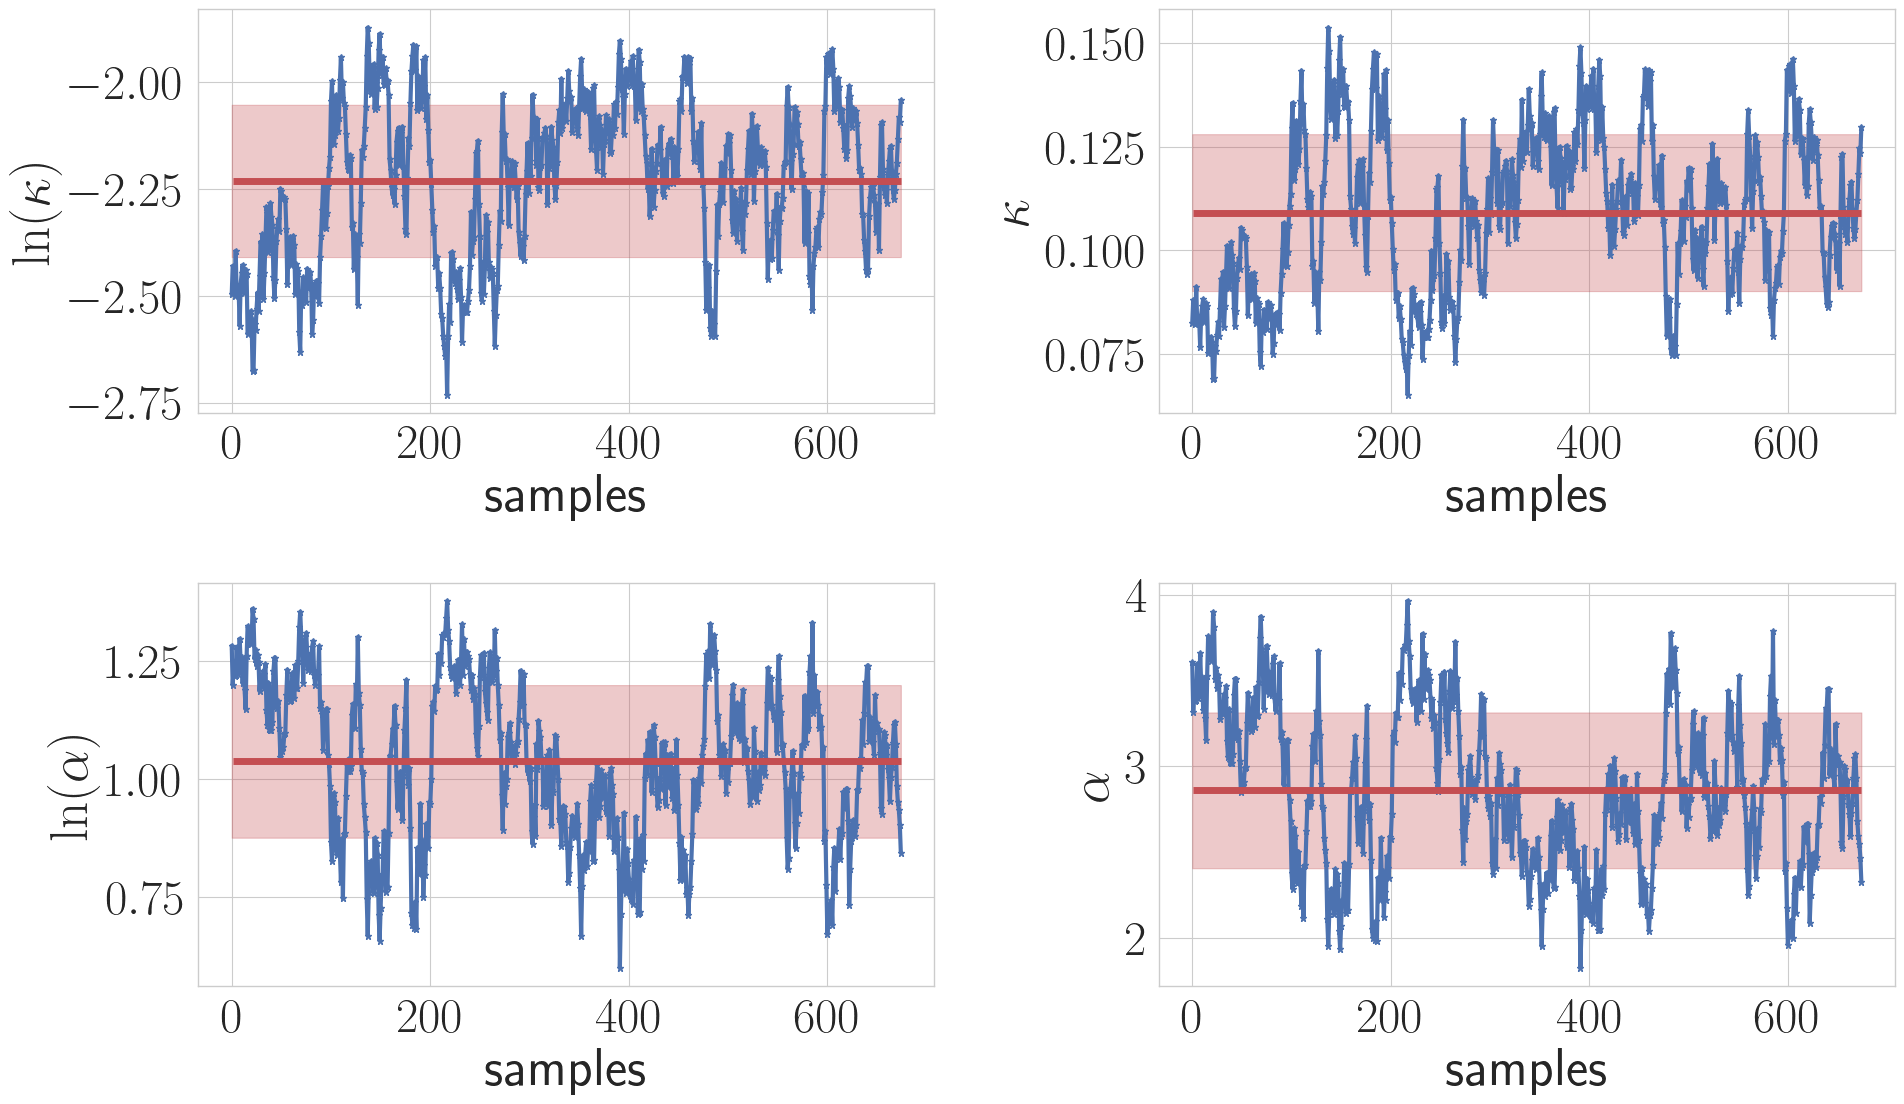

In [29]:
plot_samples = samples_chains_burn[plot_chain]

fig, axs = plt.subplots(nrows=param_dim, ncols=2, figsize=(20, 12))

# get real samples
plot_samples_real = np.exp(plot_samples)

# get mean in ln and real spaces
plot_samples_mean = [np.mean(plot_samples[:, i]) for i in range(param_dim)]
plot_samples_std = [np.std(plot_samples[:, i]) for i in range(param_dim)]

plot_samples_mean_real = [np.mean(plot_samples_real[:, i]) for i in range(param_dim)]
plot_samples_std_real = [np.std(plot_samples_real[:, i]) for i in range(param_dim)]

samples_ids = np.arange(plot_samples.shape[0])
xmin = 1
xmax = samples_ids[-1]
idx = 0
for row in range (param_dim):
    col = 0
    axs[row, col].plot(samples_ids, plot_samples[:, idx], '*-')
    # plot mean line
    axs[row, col].hlines(plot_samples_mean[idx], xmin, xmax, color = 'r', lw = 5)
    
    axs[row, col].fill_between(samples_ids, \
                    plot_samples_mean[idx] - plot_samples_std[idx], \
                    plot_samples_mean[idx] + plot_samples_std[idx], \
                    alpha=0.3, color ='r')
    
    #axs[col].set_title(titles[idx])
    axs[row, col].set_xlabel('samples')
    axs[row, col].set_ylabel(titles[idx])
    
    col = 1
    axs[row, col].plot(samples_ids, plot_samples_real[:, idx], '*-')
    # plot mean line
    axs[row, col].hlines(plot_samples_mean_real[idx], xmin, xmax, color = 'r', lw = 5)
    
    axs[row, col].fill_between(samples_ids, \
                    plot_samples_mean_real[idx] - plot_samples_std_real[idx], \
                    plot_samples_mean_real[idx] + plot_samples_std_real[idx], \
                    alpha=0.3, color ='r')
    
    #axs[col].set_title(titles[idx])
    axs[row, col].set_xlabel('samples')
    axs[row, col].set_ylabel(titles_real[idx])
    
    idx +=1
    

plt.tight_layout()
#plt.xlabel('samples')
if savefig:
    plt.savefig(sfpath_chain + 'samples_burn_{}.pdf'.format(plot_chain))

## Prior and posterior

/tmp/ipykernel_1190065/1267467604.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prior_samples[:, idx], hist=False, ax=axs[col], \
/tmp/ipykernel_1190065/1267467604.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=a

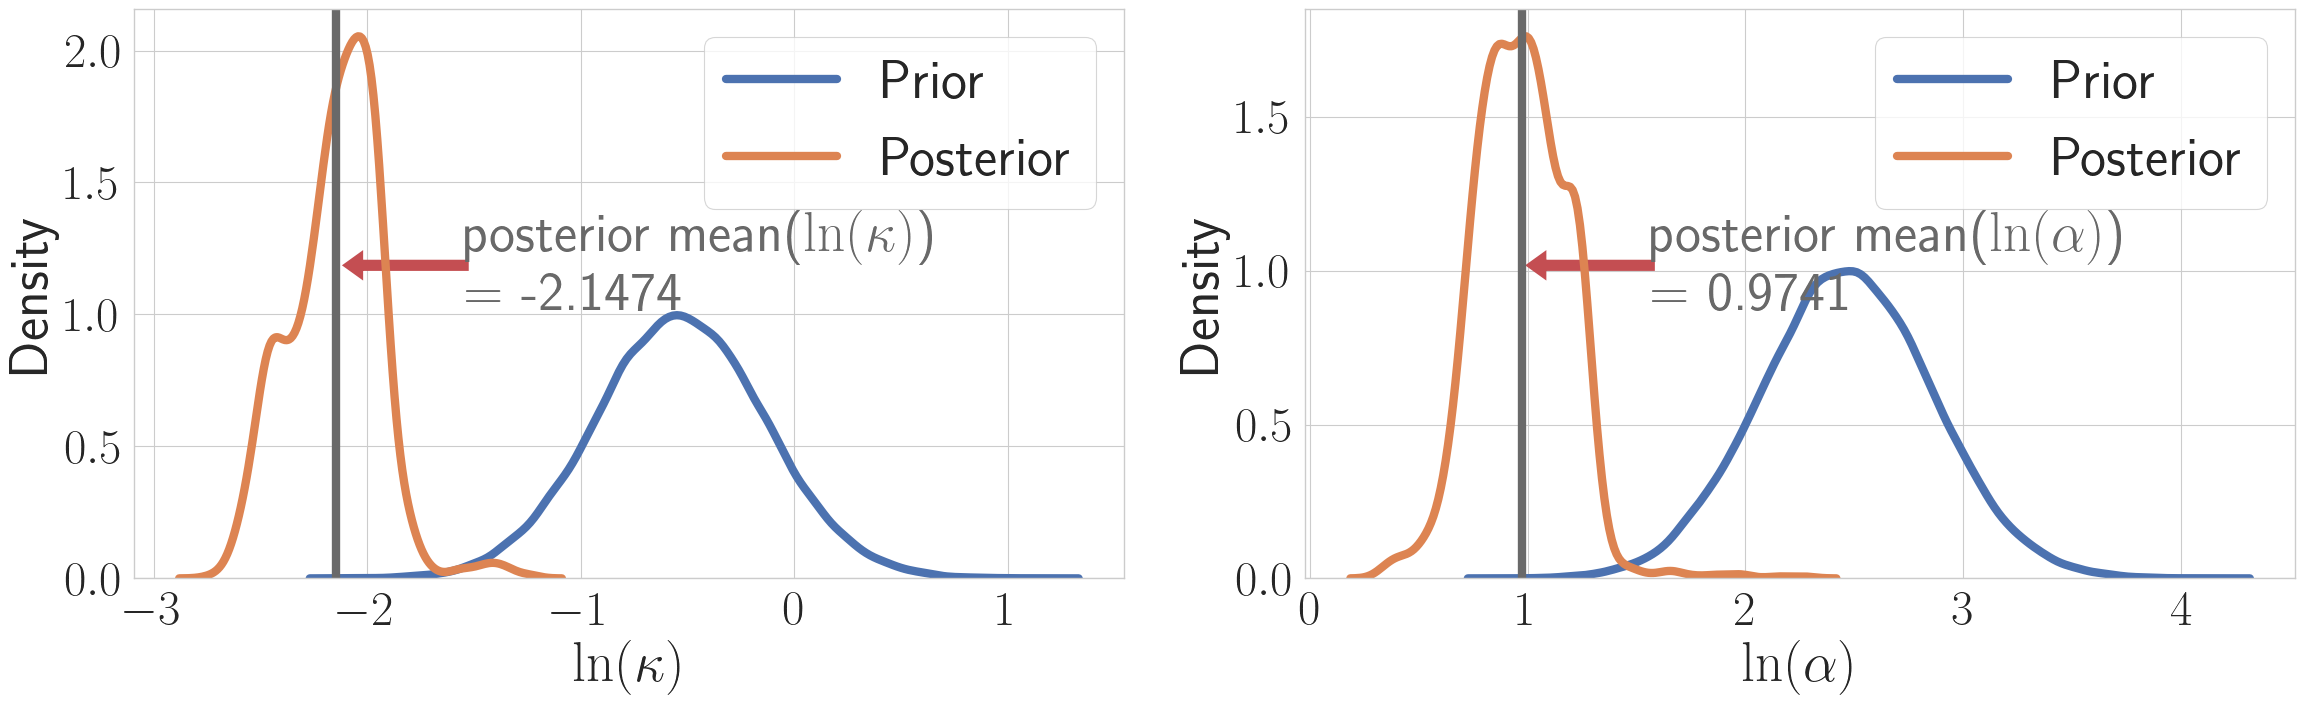

In [30]:
plot_samples = samples_chains[plot_chain]

# get mean 
plot_samples_mean = [np.mean(plot_samples[:, i]) for i in range(param_dim)]
plot_samples_std = [np.std(plot_samples[:, i]) for i in range(param_dim)]

fig, axs = plt.subplots(nrows=1, ncols=param_dim, figsize = (24,8))
lw = 6
fs = 40

idx = 0
for col in range(param_dim):
    # prior
    sns.distplot(prior_samples[:, idx], hist=False, ax=axs[col], \
                 label='Prior', \
                 kde_kws={"lw": lw})
    # posterior
    ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=axs[col],  \
                 label='Posterior', \
                 kde_kws={"lw": lw})
    
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    dx_lims = xlims[1] - xlims[0]
    dy_lims = ylims[1] - ylims[0]
    
    vline_x = plot_samples_mean[idx]
    
    text_y = 0.55 * (ylims[0] + ylims[1])
    text_x = vline_x + 0.13 * dx_lims
    text_ha_align = 'left'
    
    arrow_width = 0.005 * dy_lims
    arrow_head_width = 5 * arrow_width
    arrow_head_length = 0.01 * dx_lims
    
    arrow_dx = vline_x - text_x + 10 * arrow_width
    
    if xlims[1] - text_x < 0.4 * dx_lims:
        text_x = vline_x - 0.2 * dx_lims
        text_ha_align = 'right'
        arrow_dx = vline_x - text_x - 1 * arrow_width
    

    axs[col].axvline(x=vline_x, color='dimgray', lw = lw)
    axs[col].text(text_x, text_y, \
                       r'posterior mean(' + titles[idx] + r')' + '\n' + r'= ' + '%6.4f' % (vline_x), \
                       color = 'dimgray', va = 'center', ha = text_ha_align, fontsize = fs)
    
    
    axs[col].arrow(text_x, text_y, dx = arrow_dx, dy = 0, \
                   color = 'r', lw = lw, \
                   width = arrow_width, \
                   head_width = arrow_head_width, head_length = arrow_head_length)
    
        
    axs[col].set_xlabel(titles[idx], fontsize = fs)
    axs[col].set_ylabel(r"Density", fontsize = fs)
    axs[col].legend(fancybox=True, fontsize = fs)
    idx += 1
    
fig.tight_layout()
if savefig:
    plt.savefig(sfpath_chain + 'prior_vs_posterior_validation.pdf')

/tmp/ipykernel_1190065/1248349851.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prior_samples[:, idx], hist=False, ax=axs[col], \
/tmp/ipykernel_1190065/1248349851.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=a

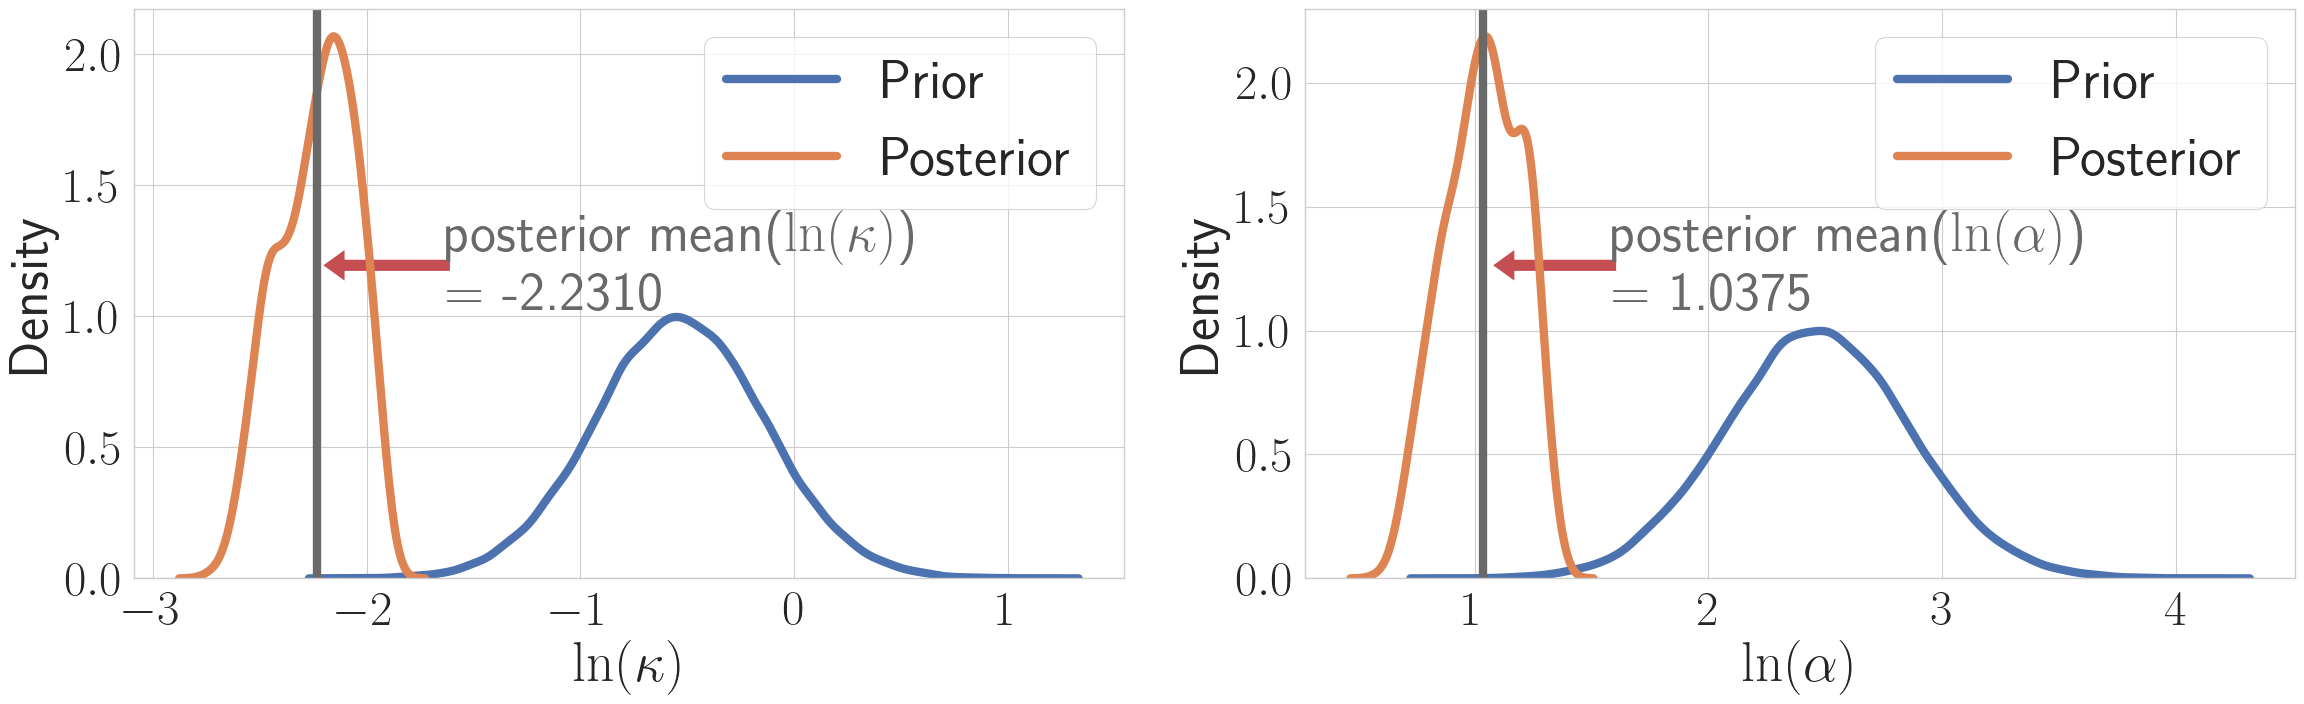

In [31]:
plot_samples = samples_chains_burn[plot_chain]

# get mean in ln and real spaces
plot_samples_mean = [np.mean(plot_samples[:, i]) for i in range(param_dim)]
plot_samples_std = [np.std(plot_samples[:, i]) for i in range(param_dim)]

fig, axs = plt.subplots(nrows=1, ncols=param_dim, figsize = (24,8))
lw = 6
fs = 40

idx = 0
for col in range(param_dim):
    # prior
    sns.distplot(prior_samples[:, idx], hist=False, ax=axs[col], \
                 label='Prior', \
                 kde_kws={"lw": lw})
    # posterior
    ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=axs[col],  \
                 label='Posterior', \
                 kde_kws={"lw": lw})
    
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    dx_lims = xlims[1] - xlims[0]
    dy_lims = ylims[1] - ylims[0]
    
    vline_x = plot_samples_mean[idx]
    
    text_y = 0.55 * (ylims[0] + ylims[1])
    text_x = vline_x + 0.13 * dx_lims
    text_ha_align = 'left'
    
    arrow_width = 0.005 * dy_lims
    arrow_head_width = 5 * arrow_width
    arrow_head_length = 0.01 * dx_lims
    
    arrow_dx = vline_x - text_x + 10 * arrow_width
    
    if xlims[1] - text_x < 0.4 * dx_lims:
        text_x = vline_x - 0.2 * dx_lims
        text_ha_align = 'right'
        arrow_dx = vline_x - text_x - 1 * arrow_width
    

    axs[col].axvline(x=vline_x, color='dimgray', lw = lw)
    axs[col].text(text_x, text_y, \
                       r'posterior mean(' + titles[idx] + r')' + '\n' + r'= ' + '%6.4f' % (vline_x), \
                       color = 'dimgray', va = 'center', ha = text_ha_align, fontsize = fs)
    
    
    axs[col].arrow(text_x, text_y, dx = arrow_dx, dy = 0, \
                   color = 'r', lw = lw, \
                   width = arrow_width, \
                   head_width = arrow_head_width, head_length = arrow_head_length)
    
        
    axs[col].set_xlabel(titles[idx], fontsize = fs)
    axs[col].set_ylabel(r"Density", fontsize = fs)
    axs[col].legend(fancybox=True, fontsize = fs)
    idx += 1
    
fig.tight_layout()
if savefig:
    plt.savefig(sfpath_chain + 'prior_vs_posterior_validation_burn.pdf')

/tmp/ipykernel_1190065/3739152032.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prior_samples[:, idx], hist=False, ax=axs[col], \
/tmp/ipykernel_1190065/3739152032.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=a

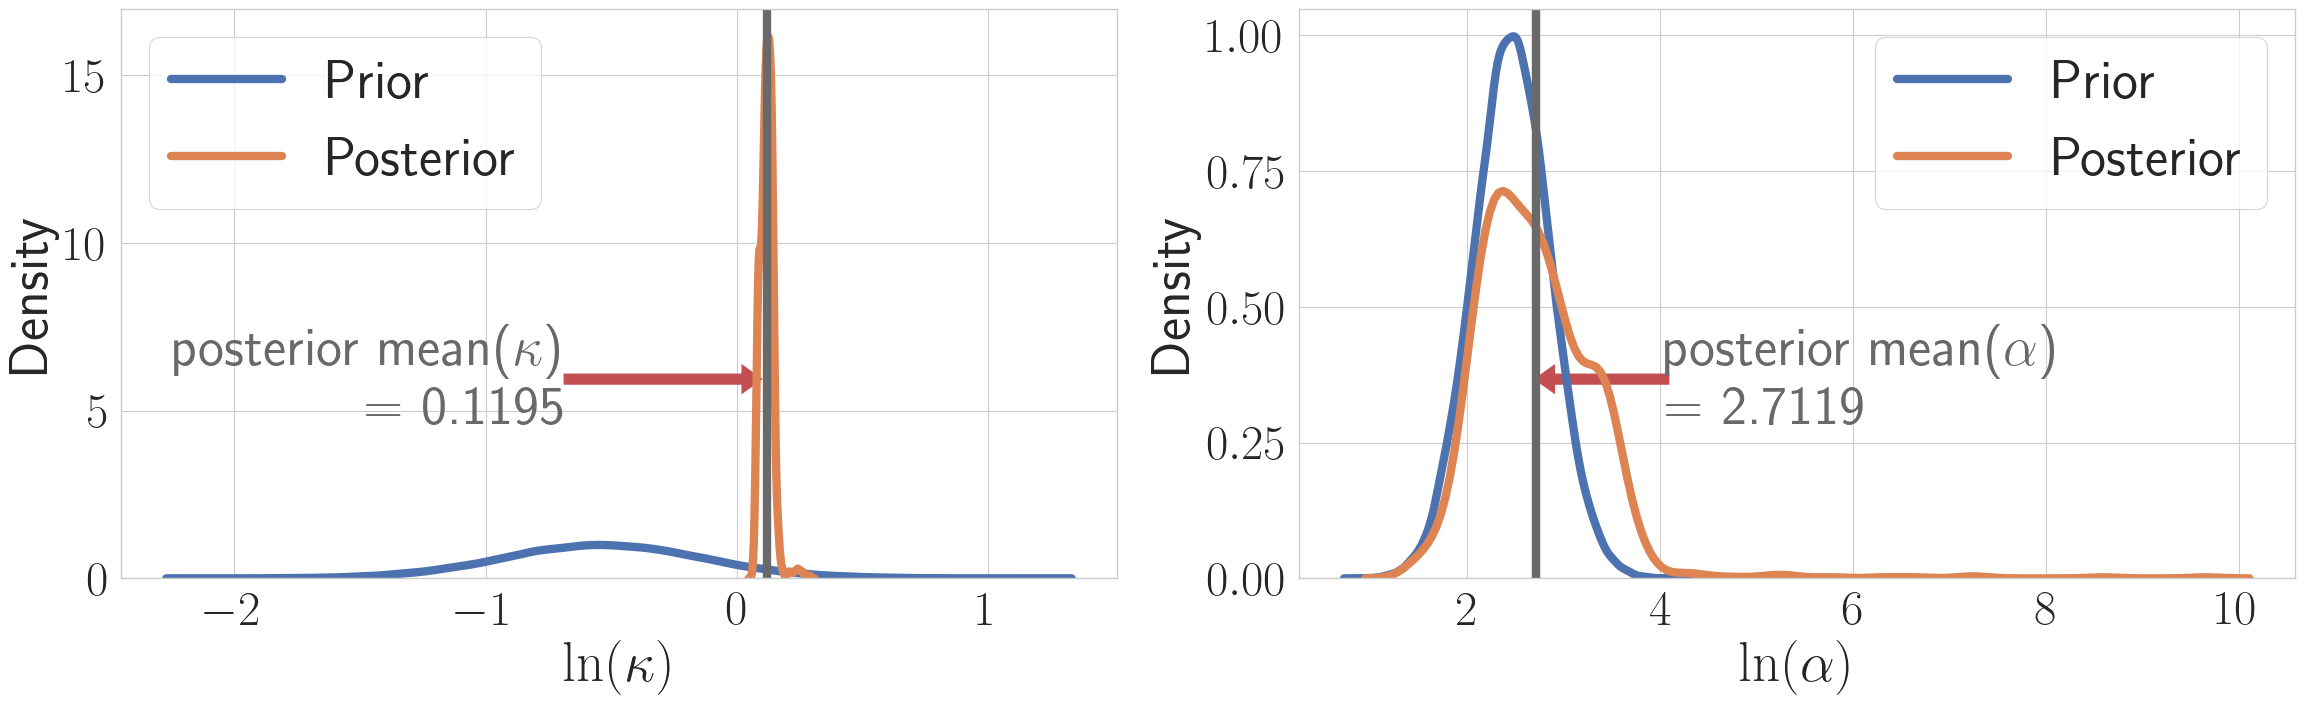

In [32]:
plot_samples = np.exp(samples_chains[plot_chain])

# get mean 
plot_samples_mean = [np.mean(plot_samples[:, i]) for i in range(param_dim)]
plot_samples_std = [np.std(plot_samples[:, i]) for i in range(param_dim)]

fig, axs = plt.subplots(nrows=1, ncols=param_dim, figsize = (24,8))
lw = 6
fs = 40

idx = 0
for col in range(param_dim):
    # prior
    sns.distplot(prior_samples[:, idx], hist=False, ax=axs[col], \
                 label='Prior', \
                 kde_kws={"lw": lw})
    # posterior
    ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=axs[col],  \
                 label='Posterior', \
                 kde_kws={"lw": lw})
    
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    dx_lims = xlims[1] - xlims[0]
    dy_lims = ylims[1] - ylims[0]
    
    vline_x = plot_samples_mean[idx]
    
    text_y = 0.35 * (ylims[0] + ylims[1])
    text_x = vline_x + 0.13 * dx_lims
    text_ha_align = 'left'
    
    arrow_width = 0.005 * dy_lims
    arrow_head_width = 5 * arrow_width
    arrow_head_length = 0.01 * dx_lims
    
    arrow_dx = vline_x - text_x + 30 * arrow_width
    
    if xlims[1] - text_x < 0.4 * dx_lims:
        text_x = vline_x - 0.2 * dx_lims
        text_ha_align = 'right'
        arrow_dx = vline_x - text_x - 1 * arrow_width
    

    axs[col].axvline(x=vline_x, color='dimgray', lw = lw)
    axs[col].text(text_x, text_y, \
                       r'posterior mean(' + titles_real[idx] + r')' + '\n' + r'= ' + '%6.4f' % (vline_x), \
                       color = 'dimgray', va = 'center', ha = text_ha_align, fontsize = fs)
    
    
    axs[col].arrow(text_x, text_y, dx = arrow_dx, dy = 0, \
                   color = 'r', lw = lw, \
                   width = arrow_width, \
                   head_width = arrow_head_width, head_length = arrow_head_length)
    
        
    axs[col].set_xlabel(titles[idx], fontsize = fs)
    axs[col].set_ylabel(r"Density", fontsize = fs)
    axs[col].legend(fancybox=True, fontsize = fs)
    idx += 1
    
fig.tight_layout()
if savefig:
    plt.savefig(sfpath_chain + 'prior_vs_posterior_real_validation.pdf')

/tmp/ipykernel_1190065/912242321.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prior_samples[:, idx], hist=False, ax=axs[col], \
/tmp/ipykernel_1190065/912242321.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=axs

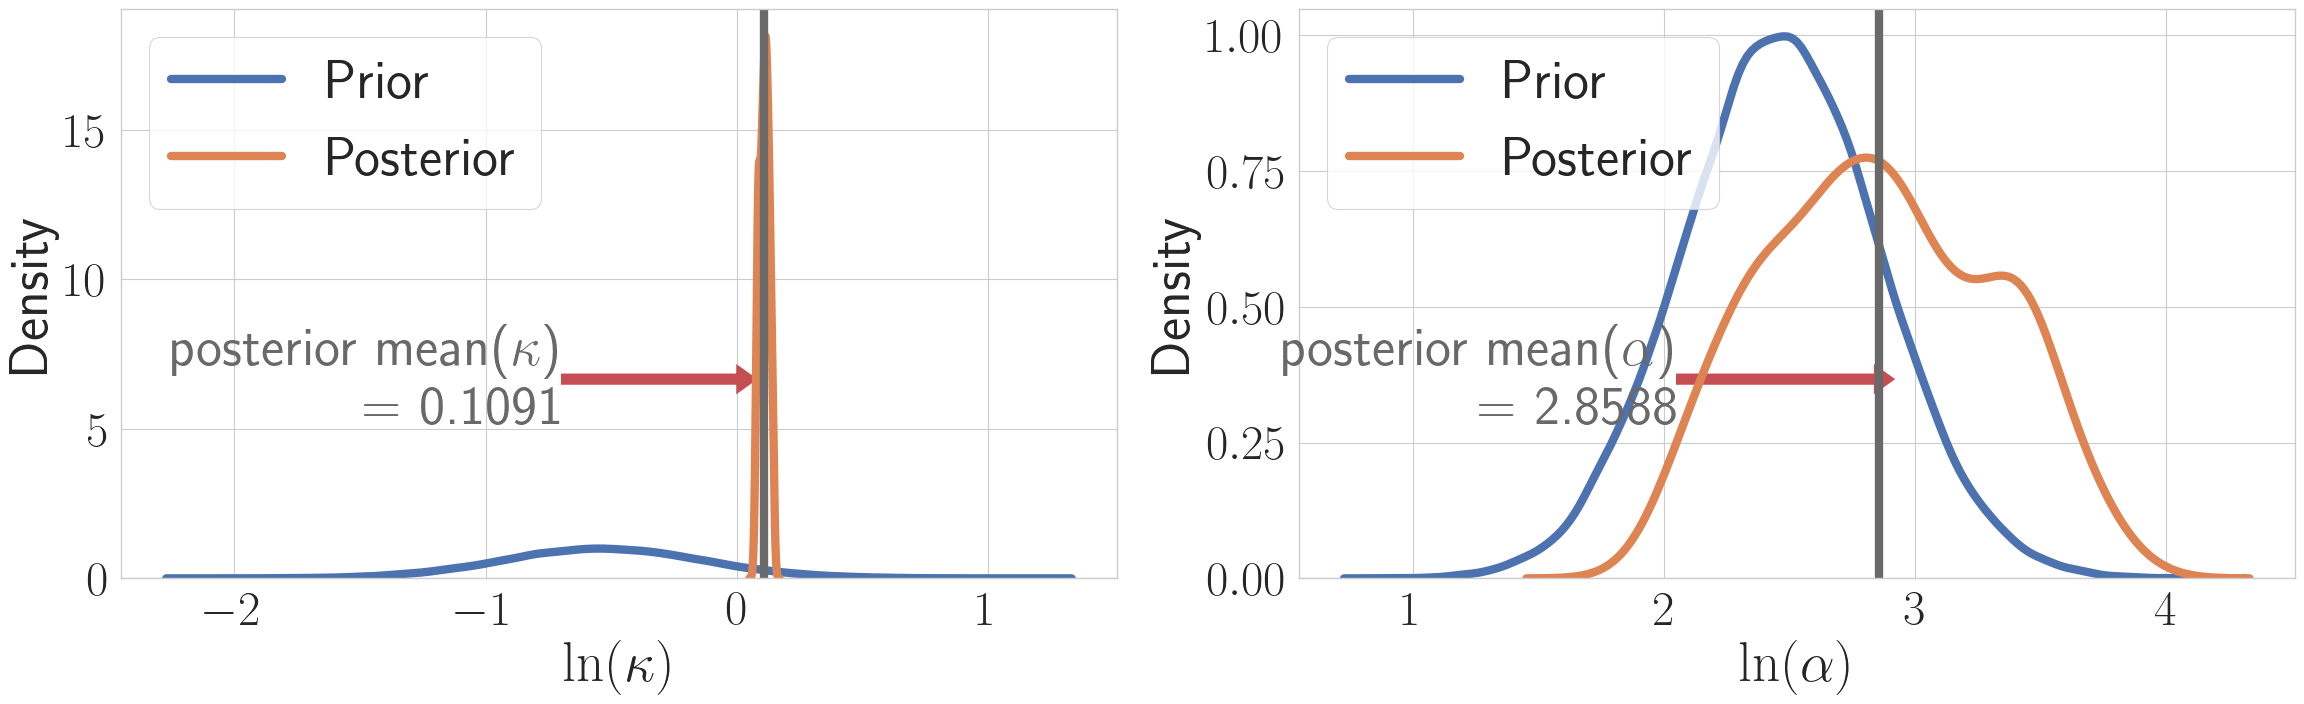

In [33]:
plot_samples = np.exp(samples_chains_burn[plot_chain])

# get mean 
plot_samples_mean = [np.mean(plot_samples[:, i]) for i in range(param_dim)]
plot_samples_std = [np.std(plot_samples[:, i]) for i in range(param_dim)]

fig, axs = plt.subplots(nrows=1, ncols=param_dim, figsize = (24,8))
lw = 6
fs = 40

idx = 0
for col in range(param_dim):
    # prior
    sns.distplot(prior_samples[:, idx], hist=False, ax=axs[col], \
                 label='Prior', \
                 kde_kws={"lw": lw})
    # posterior
    ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=axs[col],  \
                 label='Posterior', \
                 kde_kws={"lw": lw})
    
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    dx_lims = xlims[1] - xlims[0]
    dy_lims = ylims[1] - ylims[0]
    
    vline_x = plot_samples_mean[idx]
    
    text_y = 0.35 * (ylims[0] + ylims[1])
    text_x = vline_x + 0.13 * dx_lims
    text_ha_align = 'left'
    
    arrow_width = 0.005 * dy_lims
    arrow_head_width = 5 * arrow_width
    arrow_head_length = 0.01 * dx_lims
    
    arrow_dx = vline_x - text_x + 30 * arrow_width
    
    if xlims[1] - text_x < 0.4 * dx_lims:
        text_x = vline_x - 0.2 * dx_lims
        text_ha_align = 'right'
        arrow_dx = vline_x - text_x - 1 * arrow_width
    

    axs[col].axvline(x=vline_x, color='dimgray', lw = lw)
    axs[col].text(text_x, text_y, \
                       r'posterior mean(' + titles_real[idx] + r')' + '\n' + r'= ' + '%6.4f' % (vline_x), \
                       color = 'dimgray', va = 'center', ha = text_ha_align, fontsize = fs)
    
    
    axs[col].arrow(text_x, text_y, dx = arrow_dx, dy = 0, \
                   color = 'r', lw = lw, \
                   width = arrow_width, \
                   head_width = arrow_head_width, head_length = arrow_head_length)
    
        
    axs[col].set_xlabel(titles[idx], fontsize = fs)
    axs[col].set_ylabel(r"Density", fontsize = fs)
    axs[col].legend(fancybox=True, fontsize = fs)
    idx += 1
    
fig.tight_layout()
if savefig:
    plt.savefig(sfpath_chain + 'prior_vs_posterior_real_validation_burn.pdf')

# Plot combined chain

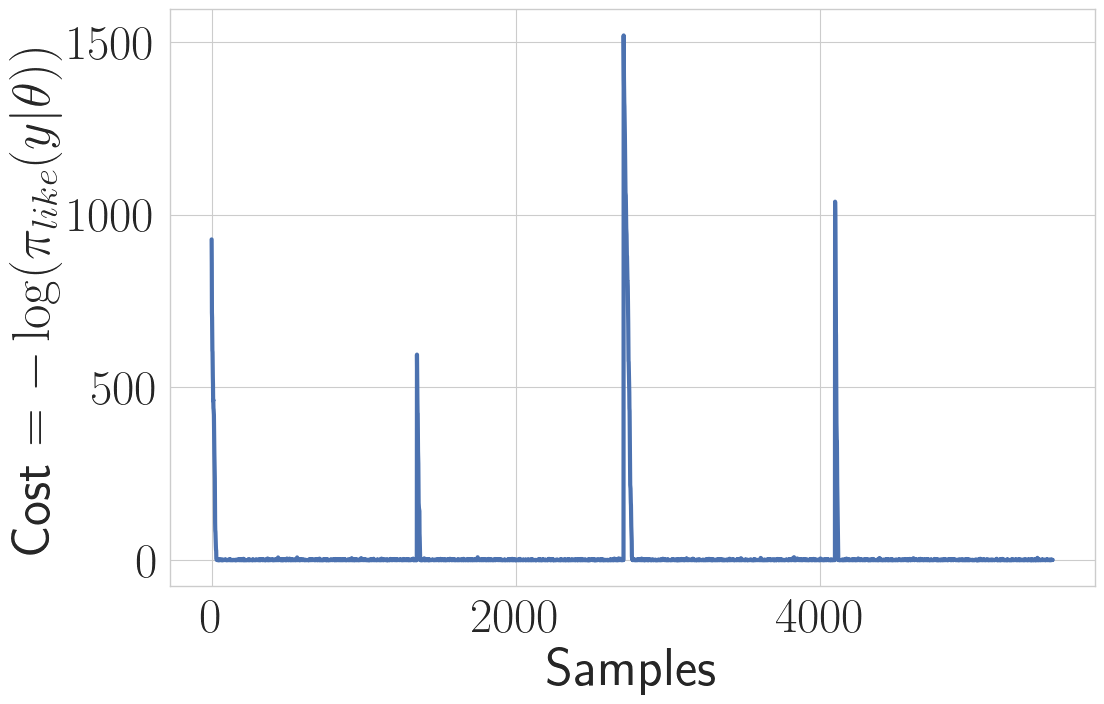

In [34]:
plot(cost, xl=r'Samples', yl= r'Cost = $-\log(\pi_{like}(y | \theta))$', \
     savefig = savefig, savefile = sfpath + 'cost.pdf', figsize=[12,8])

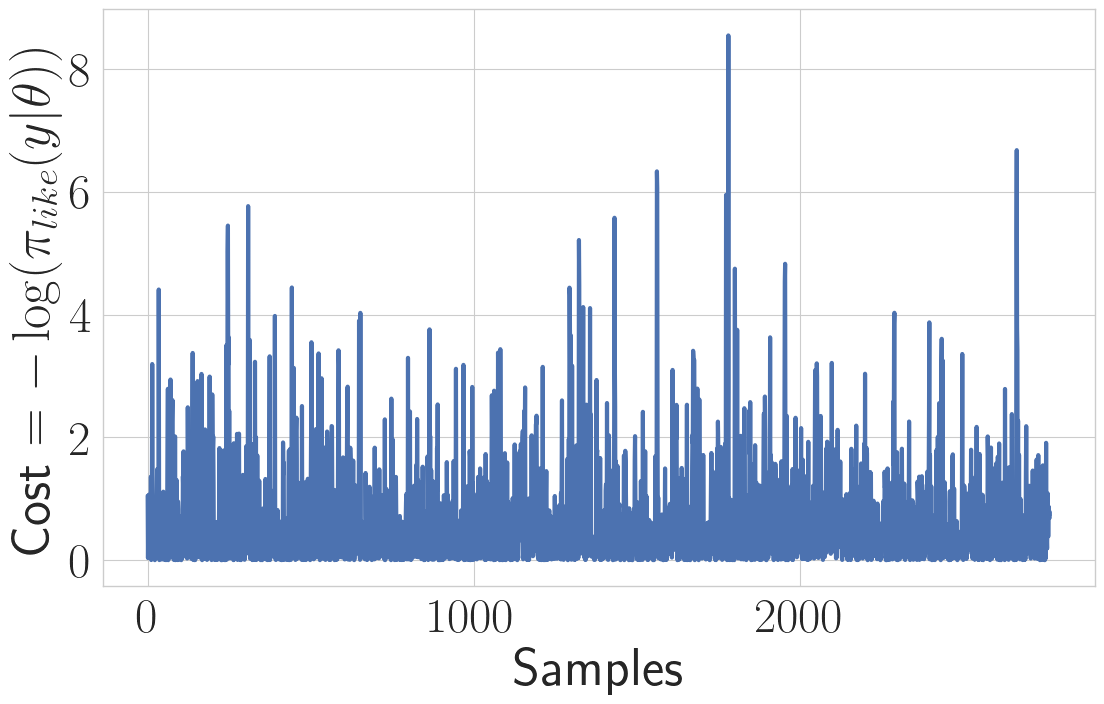

In [35]:
plot(cost_burn, xl=r'Samples', yl= r'Cost = $-\log(\pi_{like}(y | \theta))$', \
     savefig = savefig, savefile = sfpath + 'cost_burn.pdf', figsize=[12,8])

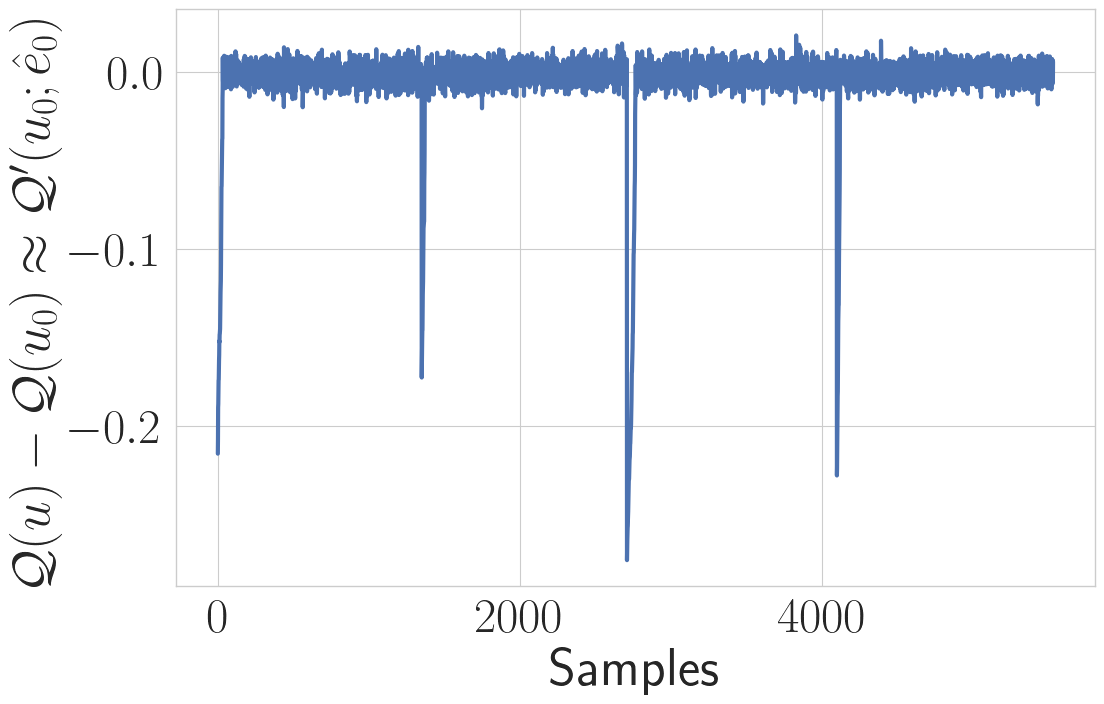

In [36]:
plot(qoi, xl=r'Samples', \
     yl=r"$\mathcal{Q}(u) - \mathcal{Q}(u_0) \approx \mathcal{Q}'(u_0; \hat{e}_0)$", \
     savefig = savefig, savefile = sfpath + 'qoi.pdf', figsize=[12,8])

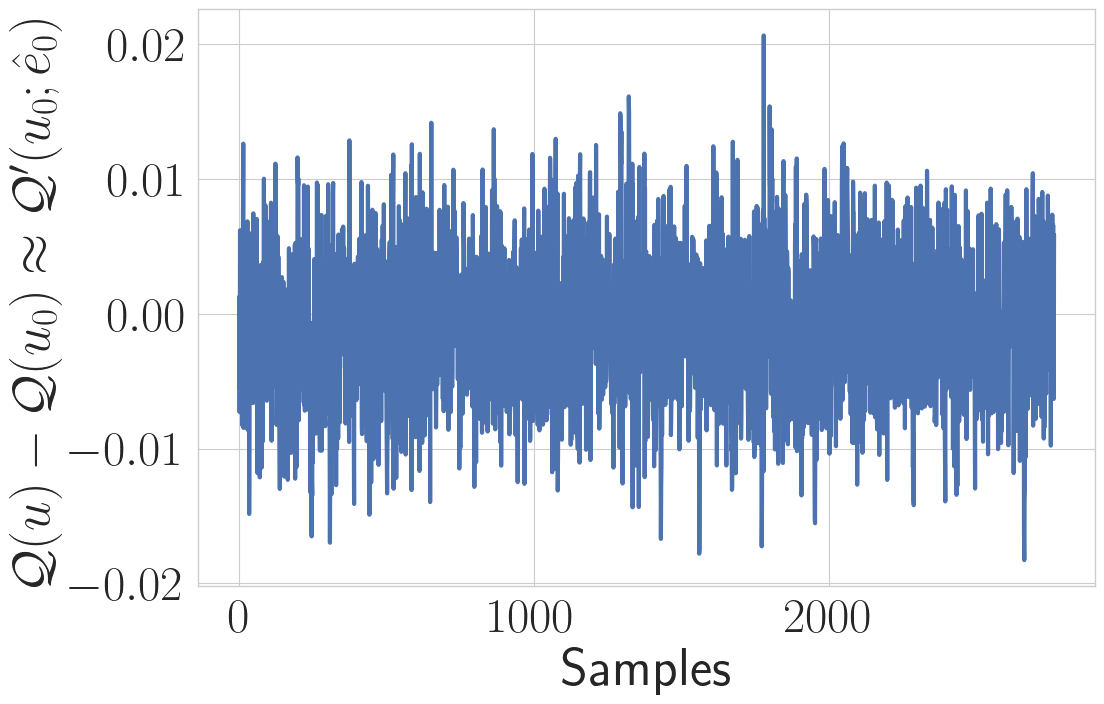

In [37]:
plot(qoi_burn, xl=r'Samples', \
     yl=r"$\mathcal{Q}(u) - \mathcal{Q}(u_0) \approx \mathcal{Q}'(u_0; \hat{e}_0)$", \
     savefig = savefig, savefile = sfpath + 'qoi_burn.pdf', figsize=[12,8])

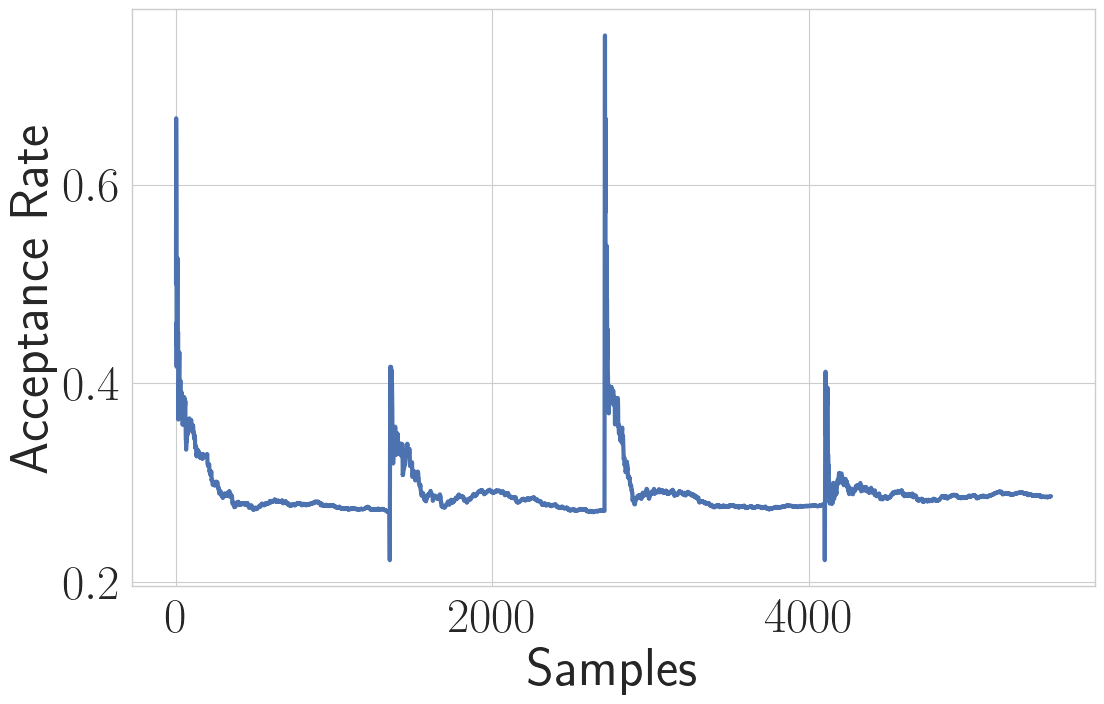

In [38]:
plot(acc, xl = r'Samples', yl= r'Acceptance Rate', \
     savefig = savefig, savefile = sfpath + 'acc.pdf', figsize=[12,8])

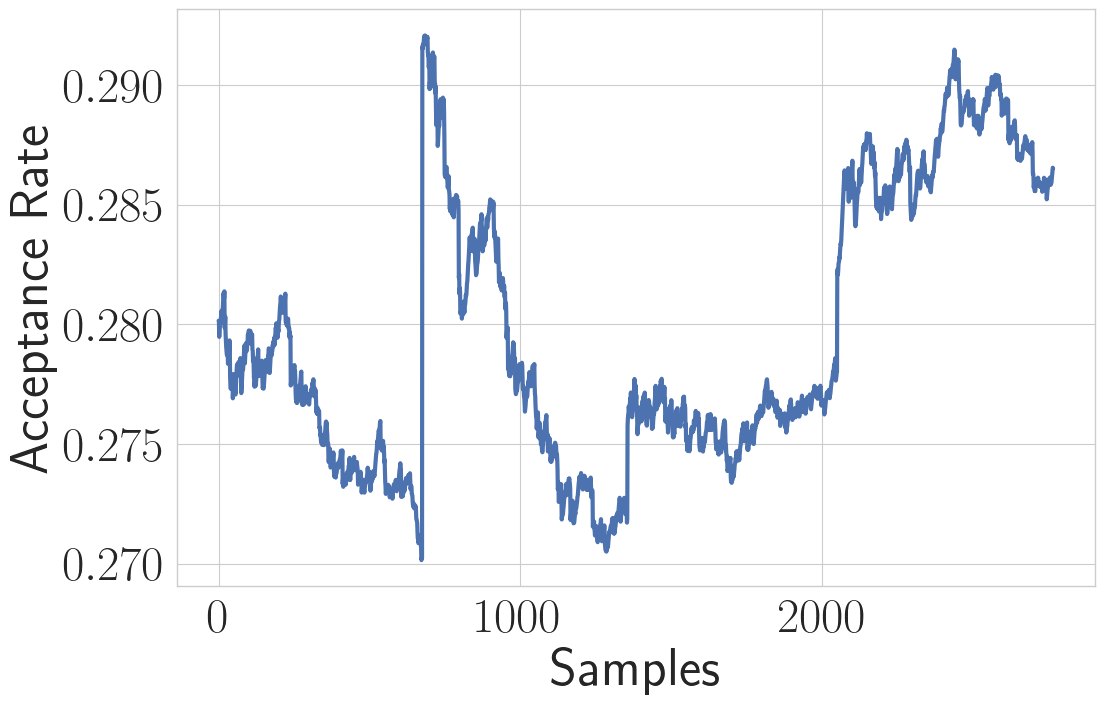

In [39]:
plot(acc_burn, xl = r'Samples', yl= r'Acceptance Rate', \
     savefig = savefig, savefile = sfpath + 'acc_burn.pdf', figsize=[12,8])

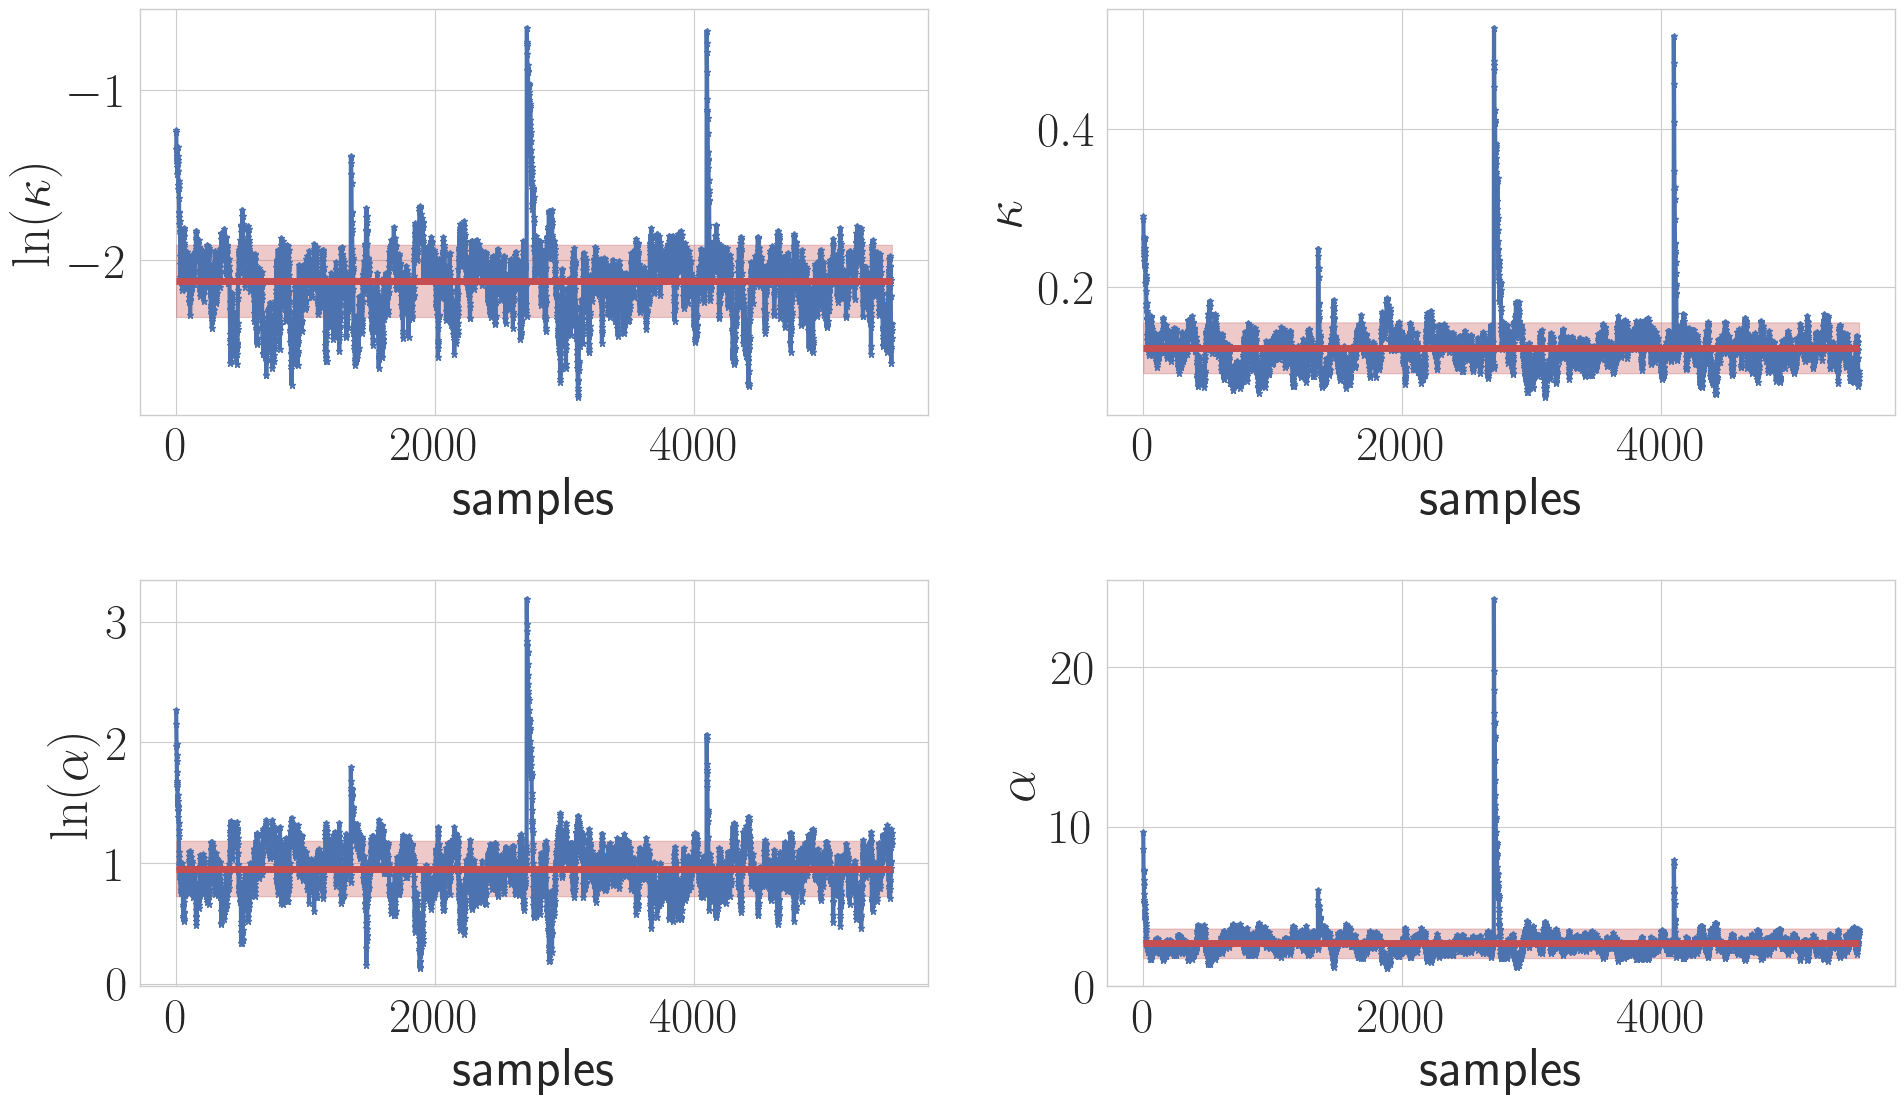

In [40]:
plot_samples = samples

fig, axs = plt.subplots(nrows=param_dim, ncols=2, figsize=(20, 12))

# get real samples
plot_samples_real = np.exp(plot_samples)

# get mean in ln and real spaces
plot_samples_mean = [np.mean(plot_samples[:, i]) for i in range(param_dim)]
plot_samples_std = [np.std(plot_samples[:, i]) for i in range(param_dim)]

plot_samples_mean_real = [np.mean(plot_samples_real[:, i]) for i in range(param_dim)]
plot_samples_std_real = [np.std(plot_samples_real[:, i]) for i in range(param_dim)]

samples_ids = np.arange(plot_samples.shape[0])
xmin = 1
xmax = samples_ids[-1]
idx = 0
for row in range (param_dim):
    col = 0
    axs[row, col].plot(samples_ids, plot_samples[:, idx], '*-')
    # plot mean line
    axs[row, col].hlines(plot_samples_mean[idx], xmin, xmax, color = 'r', lw = 5)
    
    axs[row, col].fill_between(samples_ids, \
                    plot_samples_mean[idx] - plot_samples_std[idx], \
                    plot_samples_mean[idx] + plot_samples_std[idx], \
                    alpha=0.3, color ='r')
    
    #axs[col].set_title(titles[idx])
    axs[row, col].set_xlabel('samples')
    axs[row, col].set_ylabel(titles[idx])
    
    col = 1
    axs[row, col].plot(samples_ids, plot_samples_real[:, idx], '*-')
    # plot mean line
    axs[row, col].hlines(plot_samples_mean_real[idx], xmin, xmax, color = 'r', lw = 5)
    
    axs[row, col].fill_between(samples_ids, \
                    plot_samples_mean_real[idx] - plot_samples_std_real[idx], \
                    plot_samples_mean_real[idx] + plot_samples_std_real[idx], \
                    alpha=0.3, color ='r')
    
    #axs[col].set_title(titles[idx])
    axs[row, col].set_xlabel('samples')
    axs[row, col].set_ylabel(titles_real[idx])
    
    idx +=1
    

plt.tight_layout()
#plt.xlabel('samples')
if savefig:
    plt.savefig(sfpath + 'samples.pdf')

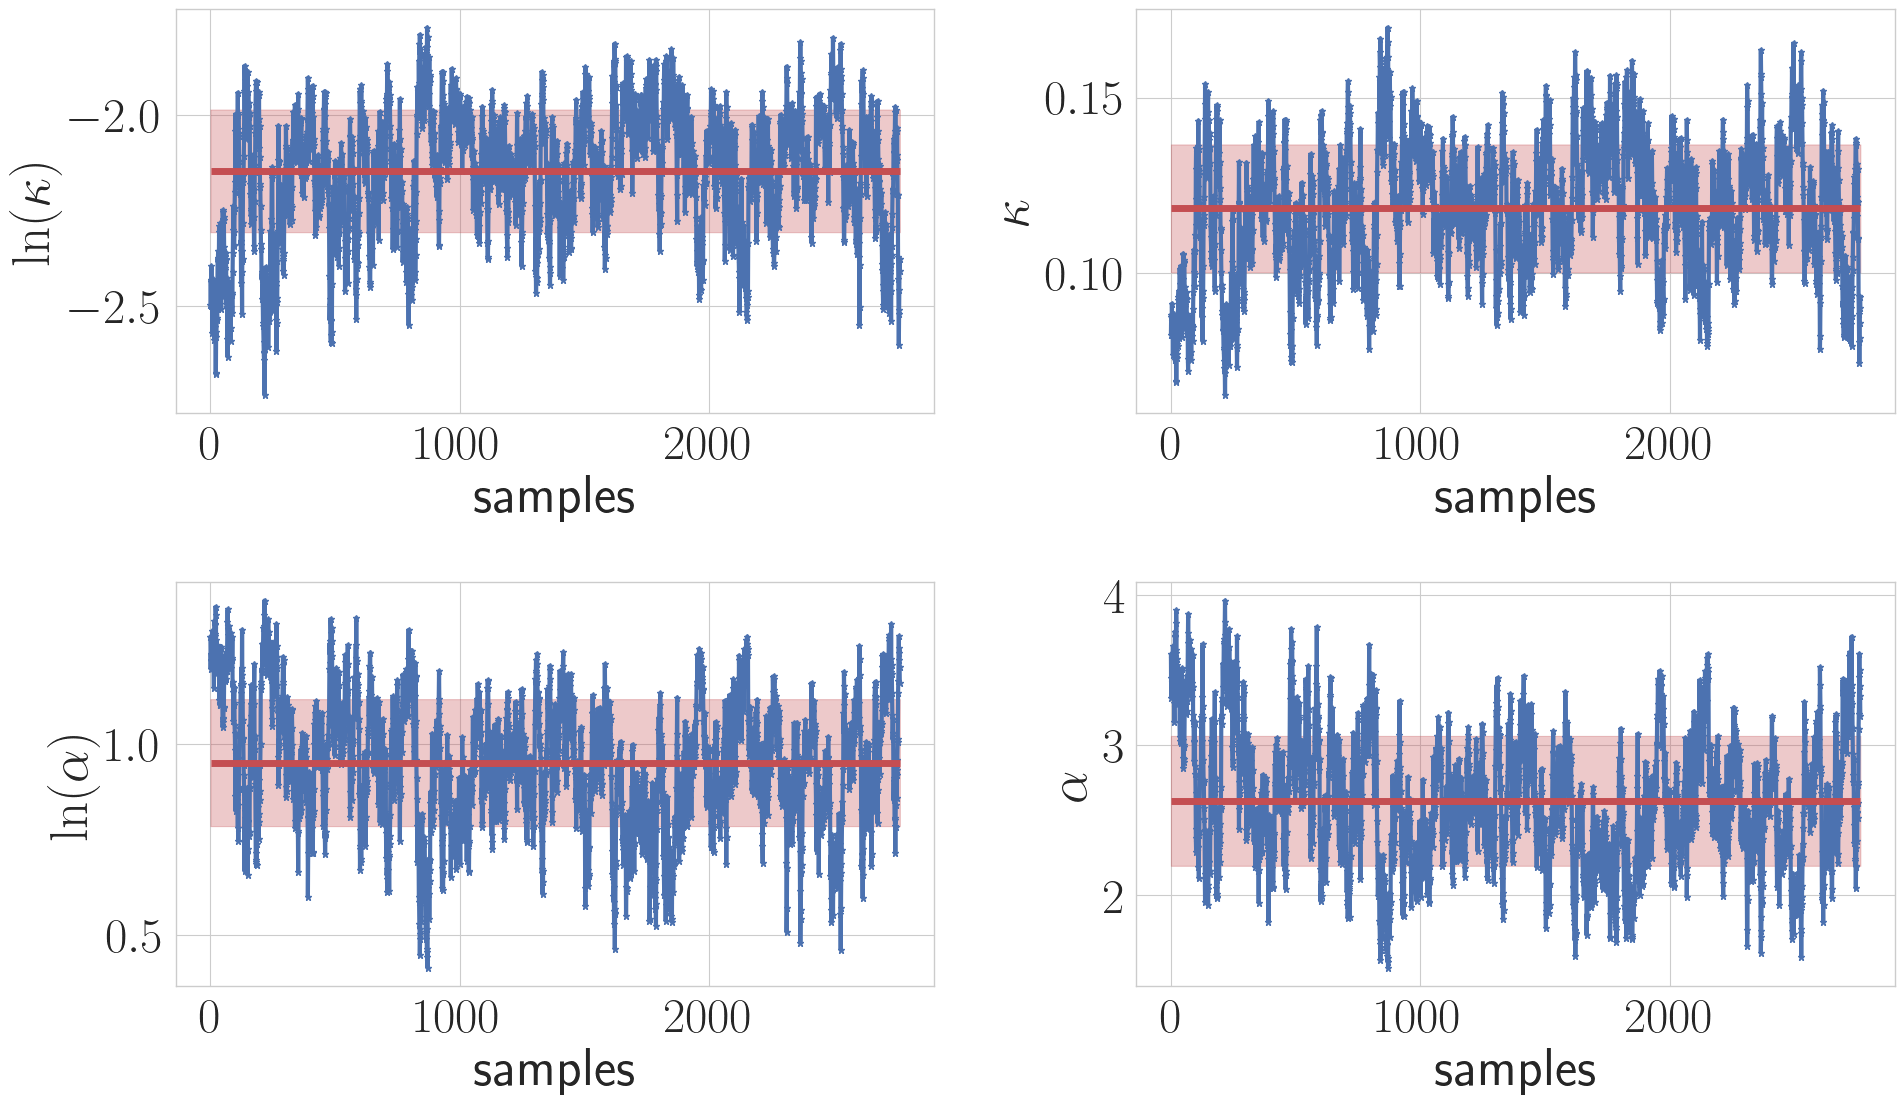

In [41]:
plot_samples = samples_burn

fig, axs = plt.subplots(nrows=param_dim, ncols=2, figsize=(20, 12))

# get real samples
plot_samples_real = np.exp(plot_samples)

# get mean in ln and real spaces
plot_samples_mean = [np.mean(plot_samples[:, i]) for i in range(param_dim)]
plot_samples_std = [np.std(plot_samples[:, i]) for i in range(param_dim)]

plot_samples_mean_real = [np.mean(plot_samples_real[:, i]) for i in range(param_dim)]
plot_samples_std_real = [np.std(plot_samples_real[:, i]) for i in range(param_dim)]

samples_ids = np.arange(plot_samples.shape[0])
xmin = 1
xmax = samples_ids[-1]
idx = 0
for row in range (param_dim):
    col = 0
    axs[row, col].plot(samples_ids, plot_samples[:, idx], '*-')
    # plot mean line
    axs[row, col].hlines(plot_samples_mean[idx], xmin, xmax, color = 'r', lw = 5)
    
    axs[row, col].fill_between(samples_ids, \
                    plot_samples_mean[idx] - plot_samples_std[idx], \
                    plot_samples_mean[idx] + plot_samples_std[idx], \
                    alpha=0.3, color ='r')
    
    #axs[col].set_title(titles[idx])
    axs[row, col].set_xlabel('samples')
    axs[row, col].set_ylabel(titles[idx])
    
    col = 1
    axs[row, col].plot(samples_ids, plot_samples_real[:, idx], '*-')
    # plot mean line
    axs[row, col].hlines(plot_samples_mean_real[idx], xmin, xmax, color = 'r', lw = 5)
    
    axs[row, col].fill_between(samples_ids, \
                    plot_samples_mean_real[idx] - plot_samples_std_real[idx], \
                    plot_samples_mean_real[idx] + plot_samples_std_real[idx], \
                    alpha=0.3, color ='r')
    
    #axs[col].set_title(titles[idx])
    axs[row, col].set_xlabel('samples')
    axs[row, col].set_ylabel(titles_real[idx])
    
    idx +=1
    

plt.tight_layout()
#plt.xlabel('samples')
if savefig:
    plt.savefig(sfpath + 'samples_burn.pdf')

## Prior and posterior

/tmp/ipykernel_1190065/2830760969.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prior_samples[:, idx], hist=False, ax=axs[col], \
/tmp/ipykernel_1190065/2830760969.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=a

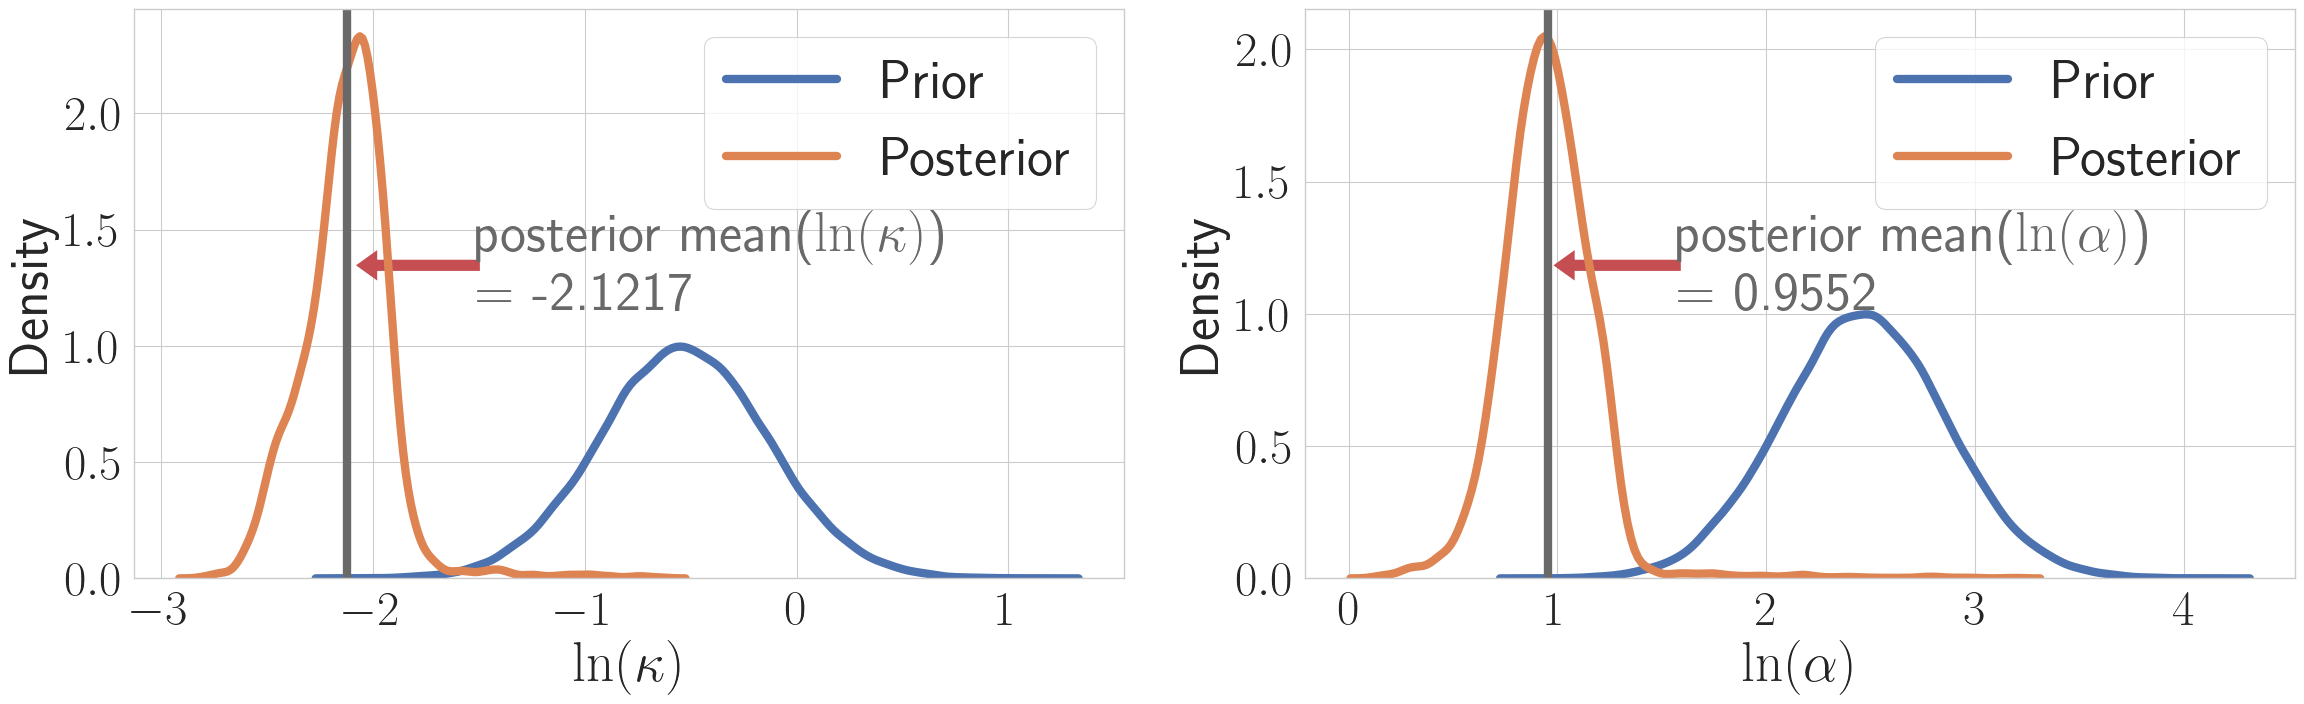

In [42]:
plot_samples = samples

# get mean 
plot_samples_mean = [np.mean(plot_samples[:, i]) for i in range(param_dim)]
plot_samples_std = [np.std(plot_samples[:, i]) for i in range(param_dim)]

fig, axs = plt.subplots(nrows=1, ncols=param_dim, figsize = (24,8))
lw = 6
fs = 40

idx = 0
for col in range(param_dim):
    # prior
    sns.distplot(prior_samples[:, idx], hist=False, ax=axs[col], \
                 label='Prior', \
                 kde_kws={"lw": lw})
    # posterior
    ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=axs[col],  \
                 label='Posterior', \
                 kde_kws={"lw": lw})
    
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    dx_lims = xlims[1] - xlims[0]
    dy_lims = ylims[1] - ylims[0]
    
    vline_x = plot_samples_mean[idx]
    
    text_y = 0.55 * (ylims[0] + ylims[1])
    text_x = vline_x + 0.13 * dx_lims
    text_ha_align = 'left'
    
    arrow_width = 0.005 * dy_lims
    arrow_head_width = 5 * arrow_width
    arrow_head_length = 0.01 * dx_lims
    
    arrow_dx = vline_x - text_x + 10 * arrow_width
    
    if xlims[1] - text_x < 0.4 * dx_lims:
        text_x = vline_x - 0.2 * dx_lims
        text_ha_align = 'right'
        arrow_dx = vline_x - text_x - 1 * arrow_width
    

    axs[col].axvline(x=vline_x, color='dimgray', lw = lw)
    axs[col].text(text_x, text_y, \
                       r'posterior mean(' + titles[idx] + r')' + '\n' + r'= ' + '%6.4f' % (vline_x), \
                       color = 'dimgray', va = 'center', ha = text_ha_align, fontsize = fs)
    
    
    axs[col].arrow(text_x, text_y, dx = arrow_dx, dy = 0, \
                   color = 'r', lw = lw, \
                   width = arrow_width, \
                   head_width = arrow_head_width, head_length = arrow_head_length)
    
        
    axs[col].set_xlabel(titles[idx], fontsize = fs)
    axs[col].set_ylabel(r"Density", fontsize = fs)
    axs[col].legend(fancybox=True, fontsize = fs)
    idx += 1
    
fig.tight_layout()
if savefig:
    plt.savefig(sfpath + 'prior_vs_posterior_validation.pdf')

/tmp/ipykernel_1190065/2031281004.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.exp(prior_samples[:, idx]), hist=False, ax=axs[col], \
/tmp/ipykernel_1190065/2031281004.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 

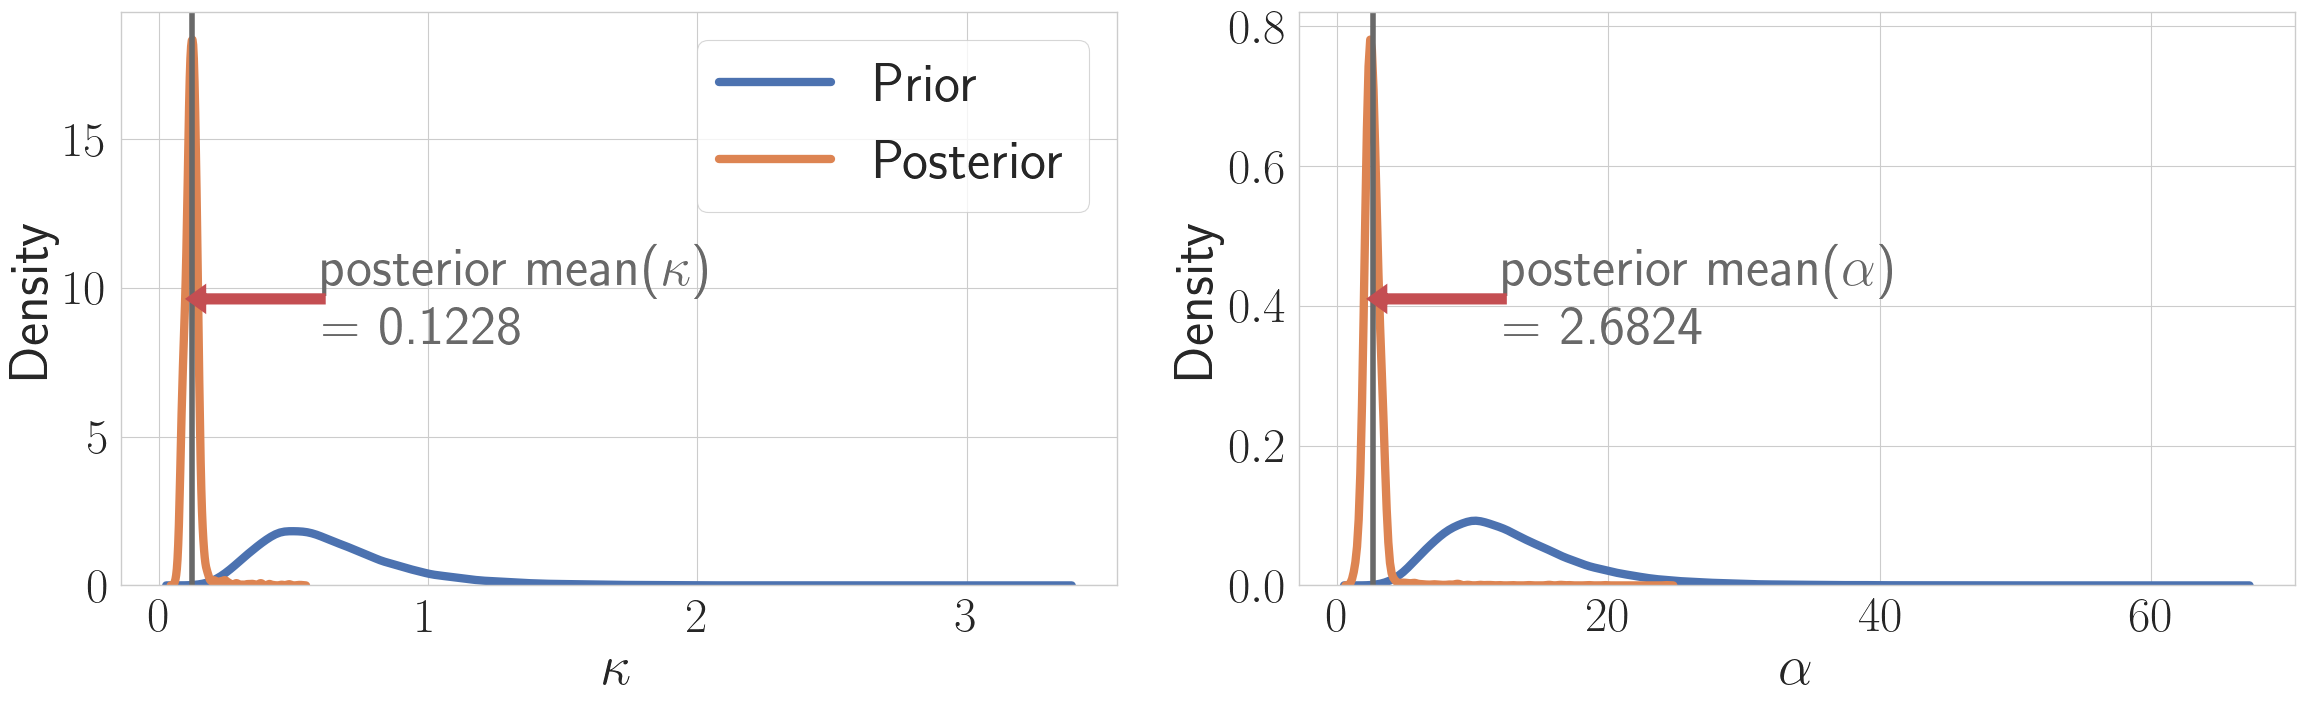

In [43]:
plot_samples = np.exp(samples)

# get mean 
plot_samples_mean = [np.mean(plot_samples[:, i]) for i in range(param_dim)]
plot_samples_std = [np.std(plot_samples[:, i]) for i in range(param_dim)]

fig, axs = plt.subplots(nrows=1, ncols=param_dim, figsize = (24,8))
lw = 6
lw_sm = 4
fs = 40

idx = 0
for col in range(param_dim):
    # prior
    sns.distplot(np.exp(prior_samples[:, idx]), hist=False, ax=axs[col], \
                 label='Prior', \
                 kde_kws={"lw": lw})
    # posterior
    ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=axs[col],  \
                 label='Posterior', \
                 kde_kws={"lw": lw})
    
    xlims = axs[col].get_xlim()
    ylims = axs[col].get_ylim()
    dx_lims = xlims[1] - xlims[0]
    dy_lims = ylims[1] - ylims[0]
    
    vline_x = plot_samples_mean[idx]
    
    text_y = ylims[0] + 0.5 * (ylims[1] - ylims[0])
    text_x = vline_x + 0.13 * dx_lims
    text_ha_align = 'left'
    
    arrow_width = 0.005 * dy_lims
    arrow_head_width = 5 * arrow_width
    arrow_head_length = 0.01 * dx_lims
    
    arrow_dx = vline_x - text_x + 0.01 * dx_lims
    
    #if xlims[1] - text_x < 0.4 * dx_lims:
    #    text_x = vline_x - 0.2 * dx_lims
    #    text_ha_align = 'right'
    #    arrow_dx = vline_x - text_x - 1 * arrow_width
    

    axs[col].axvline(x=vline_x, color='dimgray', lw = lw_sm)#, zorder = 10)
    axs[col].text(text_x, text_y, \
                       r'posterior mean(' + titles_real[idx] + r')' + '\n' + r'= ' + '%6.4f' % (vline_x), \
                       color = 'dimgray', va = 'center', ha = text_ha_align, fontsize = fs, zorder = 10)
    
    
    axs[col].arrow(text_x, text_y, dx = arrow_dx, dy = 0, \
                   color = 'r', lw = lw, \
                   width = arrow_width, \
                   head_width = arrow_head_width, head_length = arrow_head_length, zorder = 10)
    
        
    axs[col].set_xlabel(titles_real[idx], fontsize = fs)
    axs[col].set_ylabel(r"Density", fontsize = fs)
    if col == 0:
        axs[col].legend(fancybox=True, fontsize = fs)
    idx += 1
    
fig.tight_layout()
if savefig:
    plt.savefig(sfpath + 'prior_vs_posterior_real_validation.pdf')

/tmp/ipykernel_1190065/615666938.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prior_samples[:, idx], hist=False, ax=axs[col], \
/tmp/ipykernel_1190065/615666938.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=axs

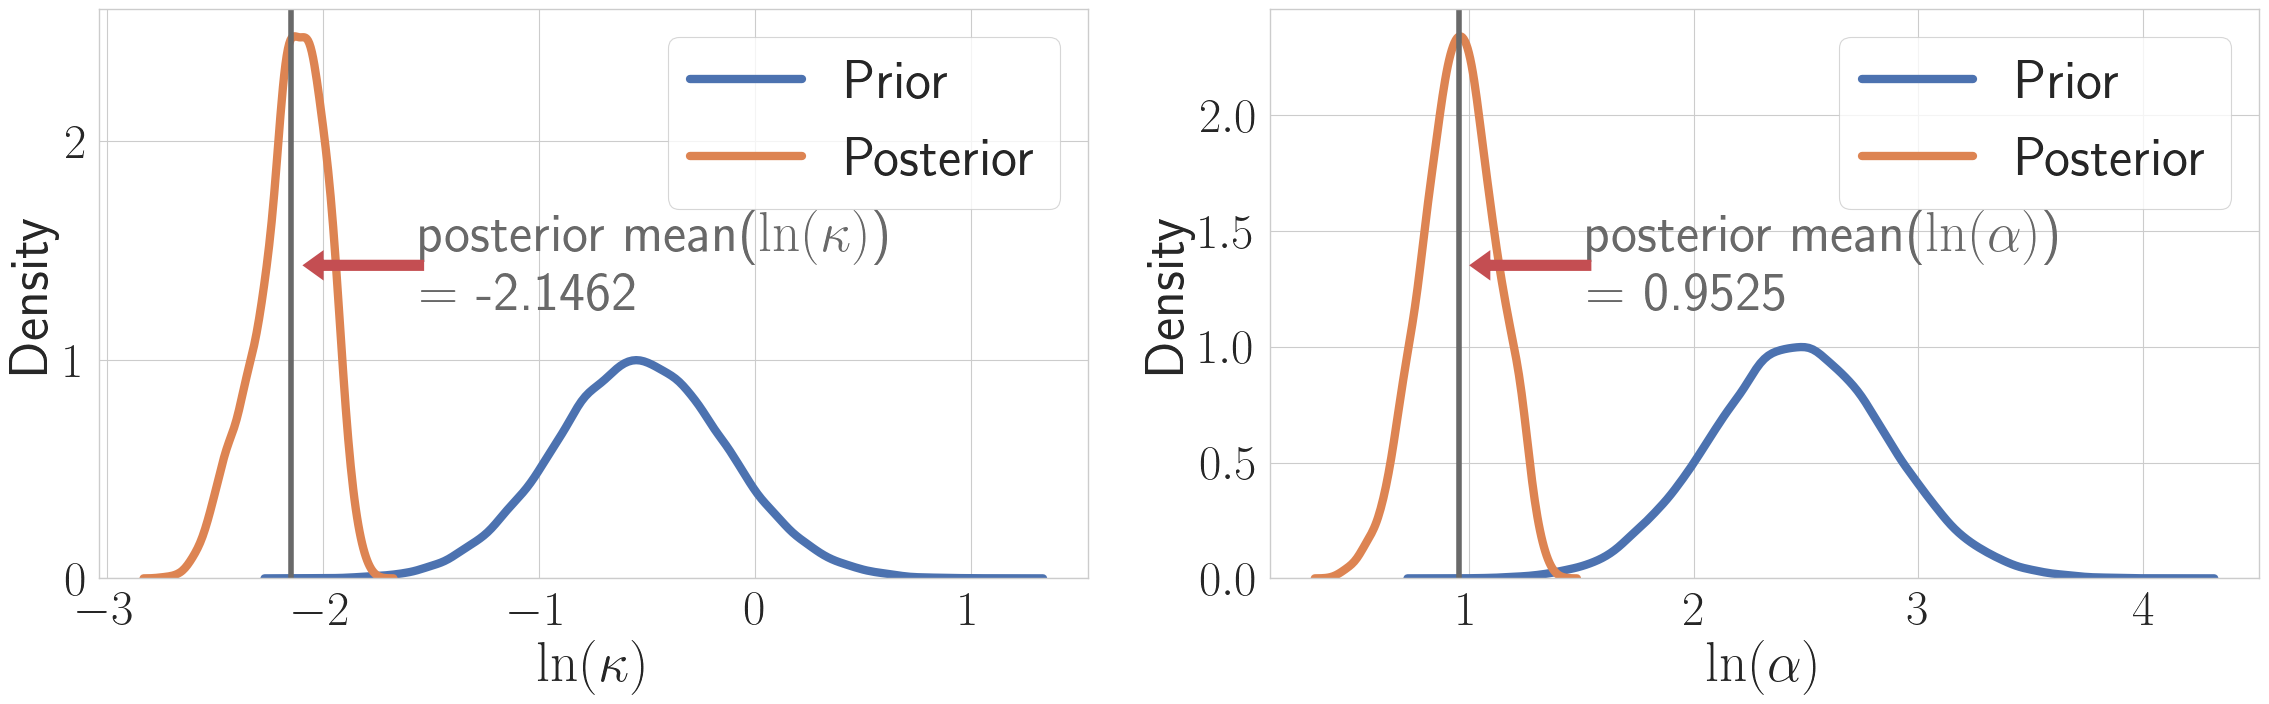

In [44]:
plot_samples = samples_burn

# get mean 
plot_samples_mean = [np.mean(plot_samples[:, i]) for i in range(param_dim)]
plot_samples_std = [np.std(plot_samples[:, i]) for i in range(param_dim)]

fig, axs = plt.subplots(nrows=1, ncols=param_dim, figsize = (24,8))
lw = 6
lw_sm = 4
fs = 40

idx = 0
for col in range(param_dim):
    # prior
    sns.distplot(prior_samples[:, idx], hist=False, ax=axs[col], \
                 label='Prior', \
                 kde_kws={"lw": lw})
    # posterior
    ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=axs[col],  \
                 label='Posterior', \
                 kde_kws={"lw": lw})
    
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    dx_lims = xlims[1] - xlims[0]
    dy_lims = ylims[1] - ylims[0]
    
    vline_x = plot_samples_mean[idx]
    
    text_y = 0.55 * (ylims[0] + ylims[1])
    text_x = vline_x + 0.13 * dx_lims
    text_ha_align = 'left'
    
    arrow_width = 0.005 * dy_lims
    arrow_head_width = 5 * arrow_width
    arrow_head_length = 0.01 * dx_lims
    
    arrow_dx = vline_x - text_x + 10 * arrow_width
    
    if xlims[1] - text_x < 0.4 * dx_lims:
        text_x = vline_x - 0.2 * dx_lims
        text_ha_align = 'right'
        arrow_dx = vline_x - text_x - 1 * arrow_width
    

    axs[col].axvline(x=vline_x, color='dimgray', lw = lw_sm)
    axs[col].text(text_x, text_y, \
                       r'posterior mean(' + titles[idx] + r')' + '\n' + r'= ' + '%6.4f' % (vline_x), \
                       color = 'dimgray', va = 'center', ha = text_ha_align, fontsize = fs, zorder=10)
    
    
    axs[col].arrow(text_x, text_y, dx = arrow_dx, dy = 0, \
                   color = 'r', lw = lw, \
                   width = arrow_width, \
                   head_width = arrow_head_width, head_length = arrow_head_length, zorder=10)
    
        
    axs[col].set_xlabel(titles[idx], fontsize = fs)
    axs[col].set_ylabel(r"Density", fontsize = fs)
    axs[col].legend(fancybox=True, fontsize = fs)
    idx += 1
    
fig.tight_layout()
if savefig:
    plt.savefig(sfpath + 'prior_vs_posterior_validation_burn.pdf')

/tmp/ipykernel_1190065/1640331308.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.exp(prior_samples[:, idx]), hist=False, ax=axs[col], \
/tmp/ipykernel_1190065/1640331308.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 

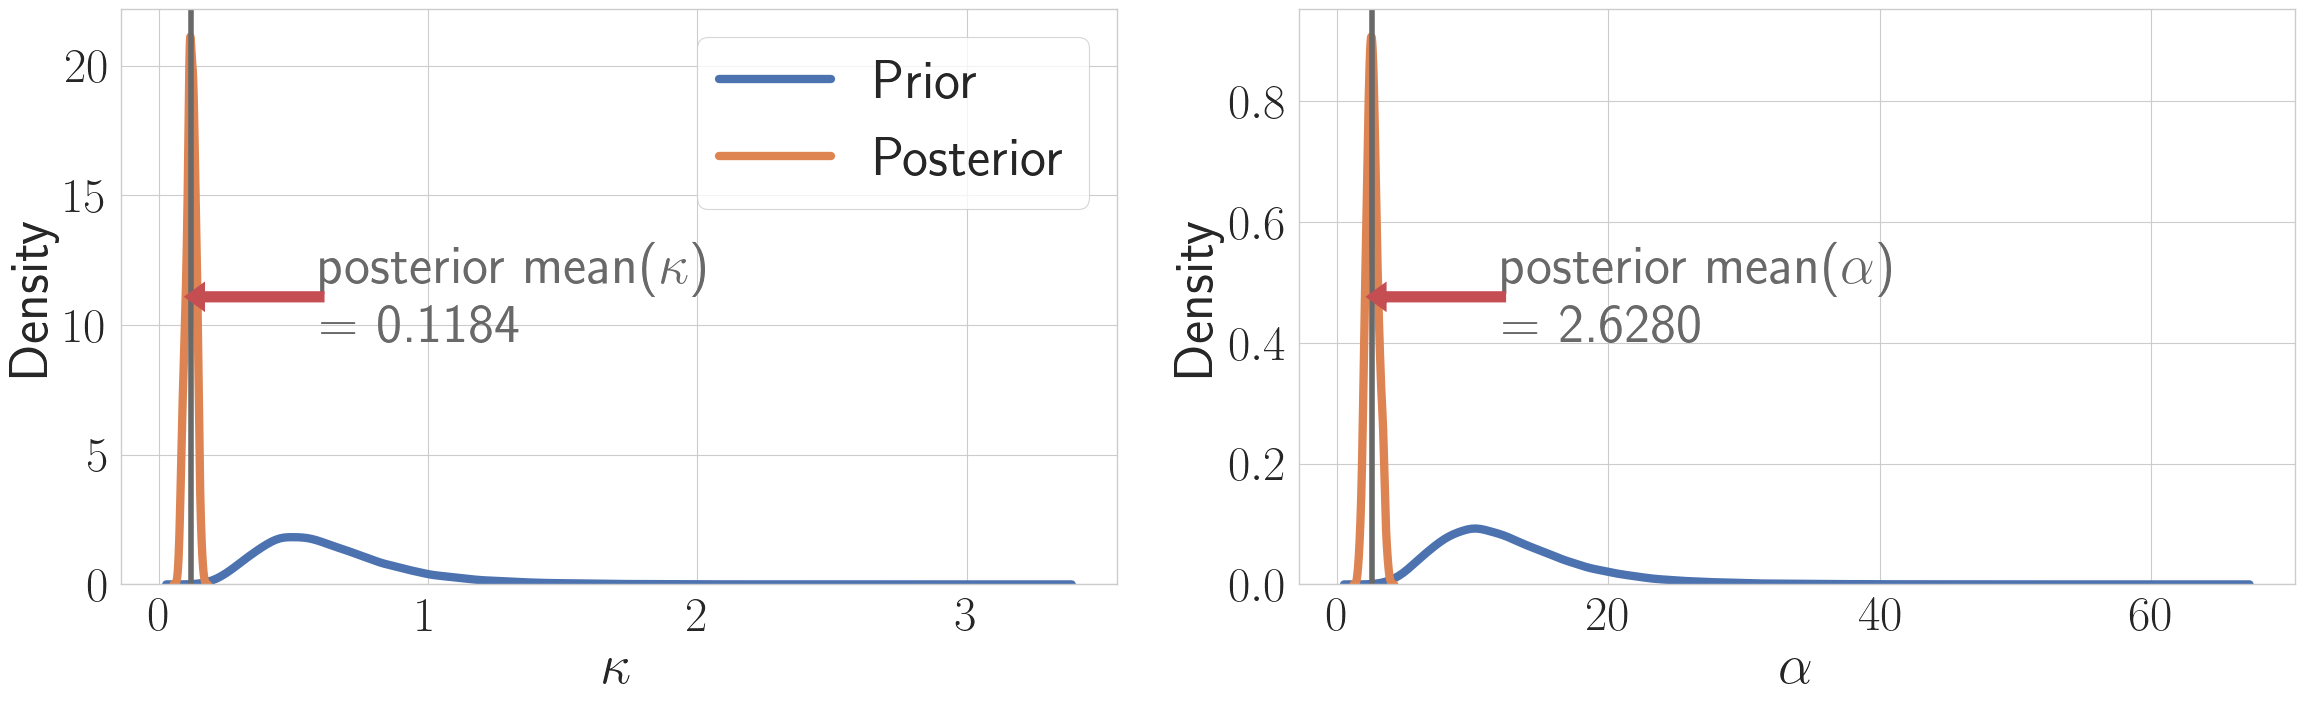

In [45]:
plot_samples = np.exp(samples_burn)
plot_samples_ln = samples_burn

# get mean 
plot_samples_mean = [np.mean(plot_samples[:, i]) for i in range(param_dim)]
plot_samples_std = [np.std(plot_samples[:, i]) for i in range(param_dim)]

plot_samples_mean_ln_exp = np.exp([np.mean(plot_samples_ln[:, i]) for i in range(param_dim)])
plot_samples_std_ln_exp = np.exp([np.std(plot_samples_ln[:, i]) for i in range(param_dim)])

fig, axs = plt.subplots(nrows=1, ncols=param_dim, figsize = (24,8))
lw = 6
lw_sm = 4
fs = 40

idx = 0
for col in range(param_dim):
    # prior
    sns.distplot(np.exp(prior_samples[:, idx]), hist=False, ax=axs[col], \
                 label='Prior', \
                 kde_kws={"lw": lw})
    # posterior
    ax = sns.distplot(plot_samples[:, idx], hist=False, bins = 25, ax=axs[col],  \
                 label='Posterior', \
                 kde_kws={"lw": lw})
    
    xlims = axs[col].get_xlim()
    ylims = axs[col].get_ylim()
    dx_lims = xlims[1] - xlims[0]
    dy_lims = ylims[1] - ylims[0]
    
    vline_x = plot_samples_mean[idx]
    #vline_x = plot_samples_mean_ln_exp[idx]
    
    text_y = ylims[0] + 0.5 * (ylims[1] - ylims[0])
    text_x = vline_x + 0.13 * dx_lims
    text_ha_align = 'left'
    
    arrow_width = 0.005 * dy_lims
    arrow_head_width = 5 * arrow_width
    arrow_head_length = 0.01 * dx_lims
    
    arrow_dx = vline_x - text_x + 0.01 * dx_lims
    
    #if xlims[1] - text_x < 0.4 * dx_lims:
    #    text_x = vline_x - 0.2 * dx_lims
    #    text_ha_align = 'right'
    #    arrow_dx = vline_x - text_x - 1 * arrow_width
    

    axs[col].axvline(x=vline_x, color='dimgray', lw = lw_sm)#, zorder = 10)
    axs[col].text(text_x, text_y, \
                       r'posterior mean(' + titles_real[idx] + r')' + '\n' + r'= ' + '%6.4f' % (vline_x), \
                       color = 'dimgray', va = 'center', ha = text_ha_align, fontsize = fs, zorder = 10)
    
    
    axs[col].arrow(text_x, text_y, dx = arrow_dx, dy = 0, \
                   color = 'r', lw = lw, \
                   width = arrow_width, \
                   head_width = arrow_head_width, head_length = arrow_head_length, zorder = 10)
    
        
    axs[col].set_xlabel(titles_real[idx], fontsize = fs)
    axs[col].set_ylabel(r"Density", fontsize = fs)
    if col == 0:
        axs[col].legend(fancybox=True, fontsize = fs)
    idx += 1
    
fig.tight_layout()
if savefig:
    plt.savefig(sfpath + 'prior_vs_posterior_real_validation_burn.pdf')

# Compute error in QoI at prior sample

In [43]:
## solve linear model
print("\n\nGetting low-fidelity solution\n")
#pde.verbosity = 3
pde.solve_fwd_bck_lf()



Getting low-fidelity solution

Solve LF problem with parameters [0.25]
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 7.005e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Calling FFC just-in-time (JIT) compiler, this may take some time.
  Newton iteration 1: r (abs) = 3.246e-15 (tol = 1.000e-10) r (rel) = 4.633e-14 (tol = 1.000e-06)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtai

In [47]:
f = open(sfpath + 'model_run.log', 'w')
m_test = dl.Vector()
prior.sample(noise, m_test)
print('test parameter: {}'.format(np.exp(m_test.get_local())))
save_suf = 'at_prior_sample'
msg = run_and_compare_approximations(m_test, pde, save_suf)

print(msg)
f.write(msg)

test parameter: [ 0.57699069 16.95517823]


save_suf = at_prior_sample




 Test parameters = [ 0.57699069 16.95517823]




Solve original forward and dual problem

Solve with parameters [ 0.57699069 16.95517823]
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 7.005e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
  Newton iteration 1: r (abs) = 4.081e-04 (tol = 1.000e-10) r (rel) = 5.826e-03 (tol = 1.000e-06)
  Newton iteration 2: r (abs) = 2.130e-08 (tol = 1.000e-10) r (rel) = 3.041e-07 (tol = 1.000e-06)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.960e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
  

796

# Compute error in QoI at mean of posterior

In [44]:
# mean and std (ln)
plot_samples = samples_burn

plot_samples_mean_ln = [np.mean(plot_samples[:, i]) for i in range(param_dim)]
plot_samples_std_ln = [np.std(plot_samples[:, i]) for i in range(param_dim)]

print('plot_samples_mean_ln = {}'.format(plot_samples_mean_ln))

plot_samples_mean_ln_exp = np.exp(plot_samples_mean_ln)
print('exp(plot_samples_mean_ln) = {}'.format(plot_samples_mean_ln_exp))

# mean and std (real)
plot_samples = np.exp(samples_burn)

plot_samples_mean_rl = [np.mean(plot_samples[:, i]) for i in range(param_dim)]
plot_samples_std_rl = [np.std(plot_samples[:, i]) for i in range(param_dim)]

print('plot_samples_mean_rl = {}'.format(plot_samples_mean_rl))

plot_samples_mean_ln = [-2.1461579130580013, 0.9525146718407502]
exp(plot_samples_mean_ln) = [0.11693256 2.59222005]
plot_samples_mean_rl = [0.11839600326539802, 2.62795995443591]


In [45]:
plot_samples_mean_rl, plot_samples_std_rl

([0.11839600326539802, 2.62795995443591],
 [0.018226433661175087, 0.43294309787404955])

In [49]:
m_test = np.log(np.array(plot_samples_mean_rl))
print('test parameter: {}'.format(plot_samples_mean_rl))
save_suf = 'at_posterior_real_mean'
msg = run_and_compare_approximations(m_test, pde, save_suf)

f.writelines(msg)

test parameter: [0.11839600326539802, 2.62795995443591]


save_suf = at_posterior_real_mean




 Test parameters = [0.118396   2.62795995]




Solve original forward and dual problem

Solve with parameters [0.118396   2.62795995]
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 7.005e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
  Newton iteration 1: r (abs) = 1.347e-02 (tol = 1.000e-10) r (rel) = 1.923e-01 (tol = 1.000e-06)
  Newton iteration 2: r (abs) = 3.967e-04 (tol = 1.000e-10) r (rel) = 5.663e-03 (tol = 1.000e-06)
  Newton iteration 3: r (abs) = 3.175e-07 (tol = 1.000e-10) r (rel) = 4.532e-06 (tol = 1.000e-06)
  Newton iteration 4: r (abs) = 2.347e-13 (tol = 1.000e-10) r (rel) = 3.351e-12 (tol = 1.000e-06)
  Newton solver finished in 4 iterations and 4 linear solver iterations.
No Jacobian form specified for nonlinear variat

In [50]:
m_test = plot_samples_mean_ln
print('test parameter: {}'.format(np.exp(plot_samples_mean_ln)))
save_suf = 'at_posterior_ln_mean'
msg = run_and_compare_approximations(m_test, pde, save_suf)

f.writelines(msg)

test parameter: [0.11693256 2.59222005]


save_suf = at_posterior_ln_mean




 Test parameters = [0.11693256 2.59222005]




Solve original forward and dual problem

Solve with parameters [0.11693256 2.59222005]
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 7.005e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
  Newton iteration 1: r (abs) = 1.383e-02 (tol = 1.000e-10) r (rel) = 1.975e-01 (tol = 1.000e-06)
  Newton iteration 2: r (abs) = 4.223e-04 (tol = 1.000e-10) r (rel) = 6.029e-03 (tol = 1.000e-06)
  Newton iteration 3: r (abs) = 3.633e-07 (tol = 1.000e-10) r (rel) = 5.186e-06 (tol = 1.000e-06)
  Newton iteration 4: r (abs) = 3.108e-13 (tol = 1.000e-10) r (rel) = 4.436e-12 (tol = 1.000e-06)
  Newton solver finished in 4 iterations and 4 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Dif

In [51]:
f.close()